# Setup

## Imports

In [1]:
# # !pip install scikit-learn==0.22.2 numpy==1.18.2 tqdm==4.43.0 torch==1.4.0 
!pip install transformers jsonpickle

     |████████████████████████████████| 778kB 4.6MB/s 
     |████████████████████████████████| 3.0MB 18.3MB/s 
     |████████████████████████████████| 890kB 54.5MB/s 
     |████████████████████████████████| 1.1MB 56.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=64e6fcc720bf51306ab92914648b9be6f5f22b5302c900d37dc932fda5d31e52
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import torch
from torch import nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from transformers import WEIGHTS_NAME, CONFIG_NAME
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import itertools
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

from typing import Tuple, List, Dict, Optional, Any
from collections import Counter
from tqdm.notebook import tqdm, trange
from pprint import pprint
import os
import json, jsonpickle

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {DEVICE}")

font = {'size': 14}
mpl.rc('font', **font)

Using device: cuda


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

Load the data from the Drive folder.

In [ ]:
hw_folder_path = "/content/drive/My Drive/Colab Notebooks/NLP/homework2"
data_folder_path = "/content/drive/My Drive/Colab Notebooks/NLP/homework2/data"
model_folder_path = "/content/drive/My Drive/Colab Notebooks/NLP/homework2/model"

In [ ]:
!ls "{data_folder_path}"

dev.json  test.json  train.json


In [ ]:
def load_data(folder: str, fname: str) -> List[Dict]:
    """
    Loads the data in a suitable format.

    Args:
        folder: The folder of the dataset
        fname:  The filename of the dataset
    Returns:
        A list of dictionaries (json-like)
    """
    path = os.path.join(folder, fname)
    with open(path, "r") as f:
        data = json.load(f)

    data = [(k, v) for k, v in data.items()]
    data = [v for k, v in sorted(data, key=lambda item: item[0])]
    
    # converting predicate index for role to int
    for elem in data:
        elem["roles"] = {int(k): v for k, v in elem["roles"].items()}

    return data

In [ ]:
train_data = load_data(data_folder_path, "train.json")
dev_data = load_data(data_folder_path, "dev.json")

In [ ]:
print(f"The train dataset contains {len(train_data)} sentences.")
print(f"The dev dataset contains {len(dev_data)} sentences.")

The train dataset contains 39279 sentences.
The dev dataset contains 1334 sentences.


# Data Analysis

In [ ]:
x = train_data[0]
print(x.keys())

dict_keys(['dependency_heads', 'dependency_relations', 'lemmas', 'pos_tags', 'predicates', 'roles', 'words'])


Data is structured in the following way:

In [ ]:
# {
#     "sentence_id": {
#         "words": ["word_0", "word_1", "...", "word_n"],
#         "lemmas": ["lemma_0", "lemma_1", "...", "lemma_n"],
#         "pos_tags": ["pos_tag_0", "pos_tag_1", "...", "pos_tag_n"],
#         "dependency_heads": ["head_0", "head_1", "...", "head_n"],
#         "dependency_relations": ["relation_0", "relation_1", "...", "relation_n"],
#         "predicates": ["sense_0", "sense_1", "...", "sense_n"],
#         "roles": {
#             "predicate_index": ["role_0", "role_1", "...", "role_n"],
#         }
#     }
# }

Let's visualize a sample from the dataset.

In [ ]:
print(" ".join(w for w in x["words"]))

In an Oct. 19 review of `` The Misanthrope '' at Chicago 's Goodman Theatre ( `` Revitalized Classics Take the Stage in Windy City , '' Leisure & Arts ) , the role of Celimene , played by Kim Cattrall , was mistakenly attributed to Christina Haag .


In [ ]:
for i in range(len(x["words"])):
    item = [i, x["words"][i], x["lemmas"][i], x["pos_tags"][i], 
            x["dependency_heads"][i], x["dependency_relations"][i],
            x["predicates"][i]]
    if i in x["roles"]:
        item.append("predicate with roles {}".format([(w, j) for j, w in enumerate(x["roles"][i]) if w != '_']))
    print(item)

[0, 'In', 'in', 'IN', '43', 'LOC', '_']
[1, 'an', 'an', 'DT', '5', 'NMOD', '_']
[2, 'Oct.', 'oct.', 'NNP', '4', 'NMOD', '_']
[3, '19', '19', 'CD', '5', 'NMOD', '_']
[4, 'review', 'review', 'NN', '1', 'PMOD', '_']
[5, 'of', 'of', 'IN', '5', 'NMOD', '_']
[6, '``', '``', '``', '9', 'P', '_']
[7, 'The', 'the', 'DT', '9', 'NMOD', '_']
[8, 'Misanthrope', 'misanthrope', 'NN', '6', 'PMOD', '_']
[9, "''", "''", "''", '9', 'P', '_']
[10, 'at', 'at', 'IN', '9', 'LOC', '_']
[11, 'Chicago', 'chicago', 'NNP', '15', 'NMOD', '_']
[12, "'s", "'s", 'POS', '12', 'SUFFIX', '_']
[13, 'Goodman', 'goodman', 'NNP', '15', 'NAME', '_']
[14, 'Theatre', 'theatre', 'NNP', '11', 'PMOD', '_']
[15, '(', '-lrb-', '(', '20', 'P', '_']
[16, '``', '``', '``', '20', 'P', '_']
[17, 'Revitalized', 'revitalize', 'VBN', '19', 'NMOD', 'AROUSE_WAKE_ENLIVEN', "predicate with roles [('Experiencer', 18)]"]
[18, 'Classics', 'classics', 'NNS', '20', 'SBJ', '_']
[19, 'Take', 'take', 'VBP', '5', 'PRN', 'TAKE', "predicate with roles [(

## Data distribution

Let's see how the predicates and roles are distributed.

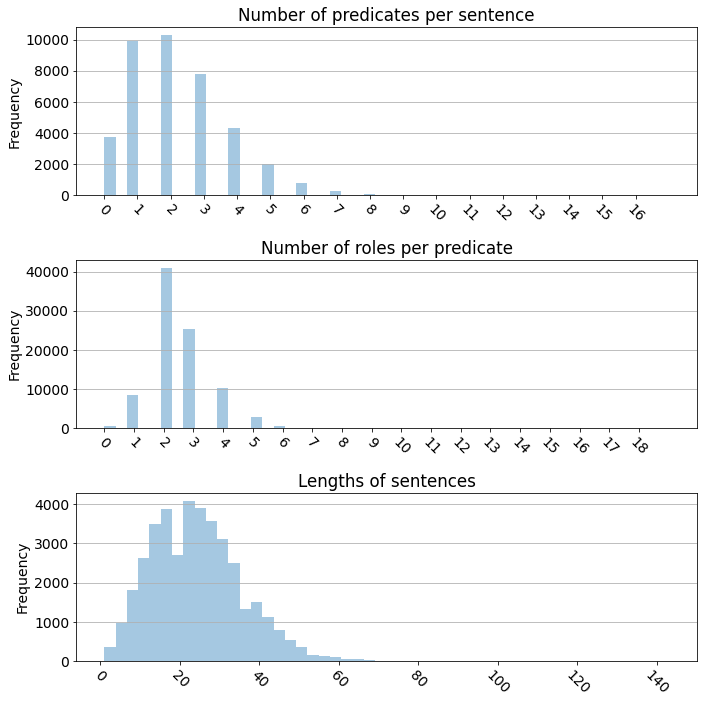

In [ ]:
sent_lengths = []
n_predicates = []
n_roles_predicate = []

for s in train_data:
    sent = s["words"]
    predicates = [(i, p) for i, p in enumerate(s["predicates"]) if p != "_"]
    n_predicates.append(len(predicates))
    sent_lengths.append(len(sent))
    for i, p in predicates:
        roles = [(j, r) for j, r in enumerate(s["roles"][i]) if r != "_"]
        n_roles_predicate.append(len(roles))

fig, ax = plt.subplots(nrows=3, figsize=(10, 10))
ax = ax.reshape(-1)

sns.distplot(n_predicates, kde=False, ax=ax[0])
ax[0].set_xticks(range(max(n_predicates)))
ax[0].xaxis.set_tick_params(rotation=-45)
ax[0].grid(axis="y")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Number of predicates per sentence")

sns.distplot(n_roles_predicate, kde=False, ax=ax[1])
ax[1].set_xticks(range(max(n_roles_predicate)))
ax[1].xaxis.set_tick_params(rotation=-45)
ax[1].grid(axis="y")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Number of roles per predicate")

sns.distplot(sent_lengths, kde=False, ax=ax[2])
ax[2].xaxis.set_tick_params(rotation=-45)
ax[2].grid(axis="y")
ax[2].set_ylabel("Frequency")
ax[2].set_title("Lengths of sentences")

fig.tight_layout()
ax[0].set_ylabel("Frequency")
plt.show()

In [ ]:
def plot_pie_chart(frequencies, labels, cutoff=5):
    """
    Plots a simple pie chart to visualize a distribution.
    
    Args:
        frequencies:    the frequencies of the distribution.
        labels:         the names of the items whose distribution we are plotting.
        cutoff:         how many items to visualize, to avoid cluttering.
    """
    # sort to have the first slice to correspond to the most frequent class
    sorted_frequencies = sorted(
        [(freq, label) for freq, label in zip(frequencies, labels)],
        key=lambda item: item[0], 
        reverse=True
    )
    
    print(sorted_frequencies[0][1])

    frequencies = [item[0] for item in sorted_frequencies]
    labels = [item[1] for item in sorted_frequencies]

    cutoff = min(cutoff, len(labels))
    labels = labels[:cutoff] + ['Others']
    frequencies = frequencies[:cutoff] + [sum(frequencies[cutoff:])]
    explode = [0.05 for _ in range(len(labels))]
    fig, ax = plt.subplots(figsize=(8, 8))
    patches, texts, autotexts = ax.pie(frequencies, labels=labels, explode=explode, 
                                       autopct='%1.1f%%', shadow=True, startangle=90)
    [ t.set_fontsize(20) for t in texts ]
    [ a.set_fontsize(20) for a in autotexts ]
    
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

Let's see how the semantic role labels (target labels), and the predicate frames are distributed.

_


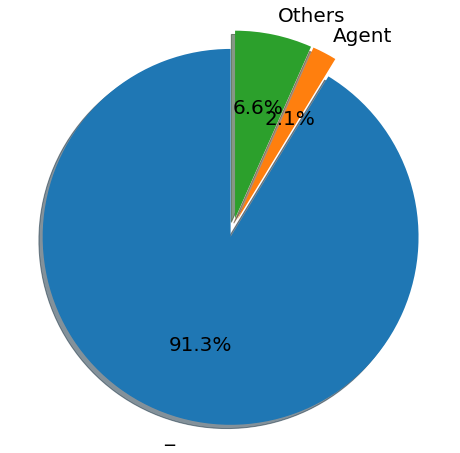

In [ ]:
# semantic_role_labels = [role for sentence in train_data for _, roles in sentence["roles"].items() for role in roles]

# srl_label_encoder = LabelEncoder()
# encoded_semantic_role_labels = srl_label_encoder.fit_transform(semantic_role_labels)
# srl_labels = srl_label_encoder.classes_

# fig, ax = plt.subplots(figsize=(20, 5))

# ax.hist(encoded_semantic_role_labels, bins=len(srl_labels))
# ax.set_xticks(range(len(srl_labels)))
# ax.set_xticklabels(srl_labels)
# ax.xaxis.set_tick_params(rotation=90)
# ax.grid(axis="y")
# ax.set_title("Distribution of semantic role labels")

# plt.show()

semantic_role_labels = [role for sentence in train_data for _, roles in sentence["roles"].items() for role in roles]

srl_label_encoder = LabelEncoder()
encoded_semantic_role_labels = srl_label_encoder.fit_transform(semantic_role_labels)

_, srl_counts = np.unique(encoded_semantic_role_labels, return_counts=True)
srl_labels = srl_label_encoder.classes_

plot_pie_chart(srl_counts, srl_labels, cutoff=2)

_


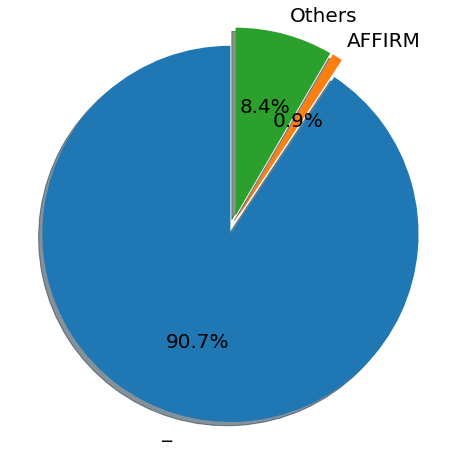

In [ ]:
# predicate_frames = [frame for sentence in train_data for frame in sentence["predicates"]]

# pf_label_encoder = LabelEncoder()
# encoded_predicate_frames = pf_label_encoder.fit_transform(predicate_frames)
# pf_labels = pf_label_encoder.classes_

# fig, ax = plt.subplots(figsize=(50, 10))

# ax.hist(encoded_predicate_frames, bins=len(pf_labels))
# ax.set_xticks(range(len(pf_labels)))
# ax.set_xticklabels(pf_labels)
# ax.xaxis.set_tick_params(rotation=90)
# ax.grid(axis="y")
# ax.set_title("Distribution of predicate frames")

# plt.show()

predicate_frames = [frame for sentence in train_data for frame in sentence["predicates"]]

pf_label_encoder = LabelEncoder()
encoded_predicate_frames = pf_label_encoder.fit_transform(predicate_frames)
pf_labels = pf_label_encoder.classes_

_, pf_counts = np.unique(encoded_predicate_frames, return_counts=True)
pf_labels = pf_label_encoder.classes_

plot_pie_chart(pf_counts, pf_labels, cutoff=2)

Clearly there are two (very large) majority classes, since most words are not predicates, and for a given predicate most words in the sentence are not its arguments.

Let's plot the distributions without those.

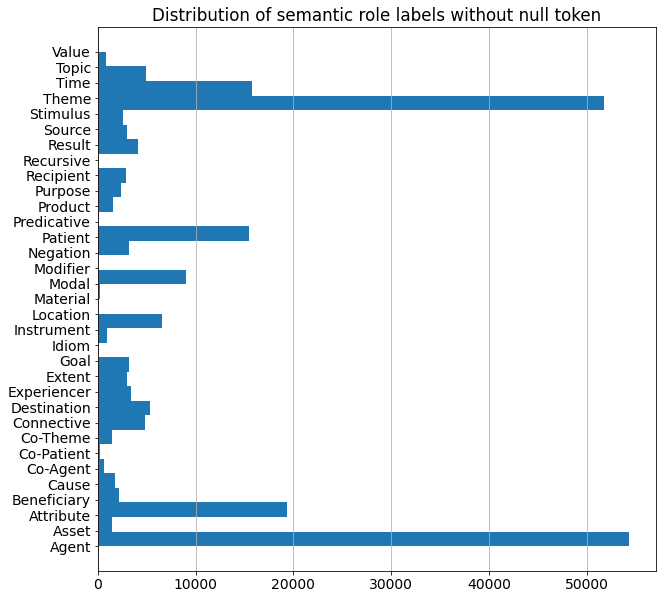

In [ ]:
srl_null_token_label = srl_label_encoder.transform(['_'])[0]

reduced_encoded_semantic_role_labels = [role for role in encoded_semantic_role_labels if role != srl_null_token_label]
fig, ax = plt.subplots(figsize=(10, 10))

ax.hist(reduced_encoded_semantic_role_labels, bins=len(srl_label_encoder.classes_),
        orientation='horizontal')
ax.set_yticks(range(len(srl_labels)-1))
ax.set_yticklabels([l for l in srl_labels if l != '_'])
# ax.xaxis.set_tick_params(rotation=90)
ax.grid(axis="x")
ax.set_title("Distribution of semantic role labels without null token")

plt.show()

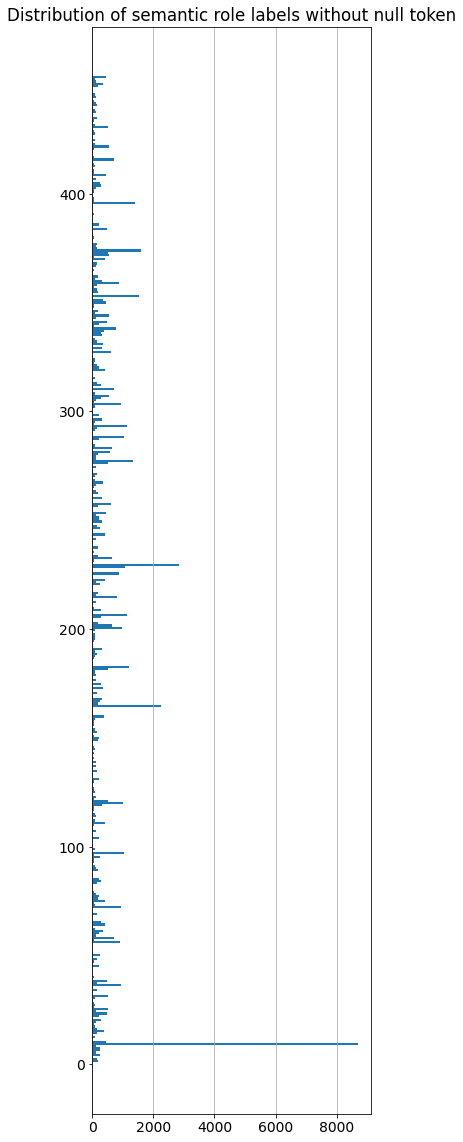

In [ ]:
pf_null_token_label = pf_label_encoder.transform(['_'])[0]

reduced_encoded_predicate_frames = [role for role in encoded_predicate_frames if role != pf_null_token_label]
fig, ax = plt.subplots(figsize=(5, 20))

ax.hist(reduced_encoded_predicate_frames, bins=len(pf_labels),
        orientation='horizontal')
# ax.set_yticks(range(len(pf_labels)-1))
# ax.set_yticklabels([l for l in pf_labels if l != '_'])
# ax.yaxis.set_tick_params(rotation=90)
ax.grid(axis="x")
ax.set_title("Distribution of semantic role labels without null token")

plt.show()

The classes distributions are still quite unbalanced, even without the null label.

# Data Preprocessing

## Utilities

Utility functions.

In [ ]:
def save_model(model, path, fname):
    fpath = os.path.join(path, fname)
    torch.save(model.state_dict(), fpath)

def load_model(model, fpath, device=DEVICE):
    model.load_state_dict(torch.load(fpath, map_location=torch.device(device)))

def json_dump(data, path, fname):
    fpath = os.path.join(path, fname)
    with open(fpath, 'w+') as f:
        frozen = jsonpickle.encode(data)
        json.dump(frozen, f, sort_keys=True)

def json_load(fpath):
    with open(fpath, 'r') as f:
        frozen = json.load(f)
        data = jsonpickle.decode(frozen)
    
    return data

## Vocabulary class(es)

In [ ]:
class Vocabulary():
    def __init__(self, counter: Counter=None, 
                 specials: List[str]=[], 
                 min_freq: int = 1,
                 only_stoi: bool = False):
        """
        Custom base vocabulary class. 

        Args:
            counter:    Counter object with token occurrences.
            specials:   List of special tokens.
            min_freq:   Minimum number of occurrences for a token to be considered in
                        the vocabulary. (default: 1, all the tokens are considered)
        
        Attributes:
            stoi (dict):    Mapping from token strings (s) to indices (i)
            only_stoi:      Hold only mapping from strings to indices
            itos (dict):    Mapping from indices (i) to token strings (s)
        """

        self.stoi = dict()
        self.only_stoi = only_stoi
        self.itos = None if self.only_stoi else []
        
        if counter is not None:
            idx = 0
            for s in specials:
                self.stoi[s] = idx
                if not self.only_stoi:
                    self.itos.append(s)
                idx += 1

            for tok, freq in counter.items():
                if freq >= min_freq:
                    self.stoi[tok] = idx
                    if not self.only_stoi:
                        self.itos.append(tok)
                    idx += 1
    
    def save(self, path: str, fname: str):
        """
        Saves the vocabulary (its two dictionaries) on disk.

        Args:
            path:   Path of the folder to save into.
            fname:  Name of the file to save onto.
        """
        state = {"stoi": self.stoi, "itos": self.itos}
        json_dump(state, path, fname)
    
    def load(self, fpath):
        """
        Loads the vocabulary (its two dictionaries) from disk.
        
        Args:
            fpath:  Path of the file to load from.
        """
        state = json_load(fpath)
        self.stoi = {s: int(i) for s, i in state["stoi"].items()}
        if not self.only_stoi:
            self.itos = [s for s in state["itos"]]
        else:
            self.itos = None

    def __getitem__(self, key):
        if type(key) == str:
            return self.stoi[key]
        elif not self.only_stoi and type(key) == int:
            return self.itos[key]
        elif self.only_stoi and type(key) == int:
            raise NotImplementedError("This vocabulary holds only the mapping from strings to indices")
        else:
            raise KeyError("{} is neither a token nor an index".format(key))
    
    def __len__(self):
        return len(self.itos)
    
    def __contains__(self, key):
        if type(key) == str:
            return key in self.stoi
        elif not self.only_stoi and type(key) == int:
            return key >= 0 and key < len(self.itos)
        elif self.only_stoi and type(key) == int:
            raise NotImplementedError("This vocabulary holds only the mapping from strings to indices")
        else:
            raise KeyError("{} is neither a token nor an index".format(key))

In [ ]:
class PredicateFramesVocabulary(Vocabulary):
    def __init__(self, counter: Counter=None, specials: List[str]=[], min_freq: int = 1):
        """
        Vocabulary to hold the predicate frames.

        Args:
            see base class.
        """
        super().__init__(counter, specials, min_freq)

In [ ]:
class SemanticRolesVocabulary(Vocabulary):
    def __init__(self, counter: Counter=None, specials: List[str]=[], min_freq: int = 1):        
        """
        Vocabulary to hold the predicate frames.

        Args:
            see base class.
        """
        super().__init__(counter, specials, min_freq)
    
    def encode(self, labels: List[str]) -> List[int]:
        """
        Encodes a list of tokens (semantic roles) into a list of indices.

        Args:
            labels: List of semantic role labels for the sentence
        Returns:
            The list of indices corresponding to the input semantic role labels.
        """
        indices = list()
        for label in labels:
            if label in self.stoi: # vocabulary string to integer
                indices.append(self[label])
            else:
                raise KeyError("Dictionary incomplete")
        return indices

In [ ]:
class WordsVocabulary(Vocabulary):
    def __init__(self, counter: Counter=None, specials: List[str]=[], min_freq: int = 1):
        """
        Vocabulary to hold the words.

        Args:
            see base class.
        """
        super().__init__(counter, specials, min_freq)
    
    def encode(self, words: List[str]) -> List[int]:
        """
        Encodes a list of tokens (words) into a list of indices.

        Args:
            words: List of words for the sentence.
        Returns:
            The list of indices corresponding to the input words.
        """
        indices = list()
        for word in words:
            if word in self.stoi: # vocabulary string to integer
                indices.append(self[word])
            else:
                indices.append(self["<unk>"])
        return indices

In [ ]:
class LemmasVocabulary(Vocabulary):
    def __init__(self, counter: Counter=None, specials: List[str]=[], min_freq: int = 1):
        """
        Vocabulary to hold the lemmas.

        Args:
            see base class.
        """
        super().__init__(counter, specials, min_freq)
    
    def encode(self, lemmas: List[str]) -> List[int]:
        """
        Encodes a list of tokens (lemmas) into a list of indices.

        Args:
            lemmas: List of semantic lemmas for the sentence
        Returns:
            The list of indices corresponding to the input lemmas.
        """
        indices = list()
        for lemma in lemmas:
            if lemma in self.stoi: # vocabulary string to integer
                indices.append(self[lemma])
            else:
                indices.append(self["<unk>"])
        return indices

In [ ]:
class POSTagsVocabulary(Vocabulary):
    def __init__(self, counter: Counter=None, specials: List[str]=[], min_freq: int = 1):
        """
        Vocabulary to hold the POS tags.

        Args:
            see base class.
        """
        super().__init__(counter, specials, min_freq)
    
    def encode(self, tags: List[str]) -> List[int]:
        """
        Encodes a list of tokens (POS tags) into a list of indices.

        Args:
            tags: List of POS tags for the sentence.
        Returns:
            The list of indices corresponding to the input pos tags.
        """
        indices = list()
        for tag in tags:
            if tag in self.stoi: # vocabulary string to integer
                indices.append(self[tag])
            else:
                indices.append(self["<unk>"])
        return indices

In [ ]:
# class DependencyRelationsVocabulary(Vocabulary):
#     def __init__(self, counter: Counter=None, specials: List[str]=[], min_freq: int = 1):
#         super().__init__(counter, specials, min_freq)
    
#     def encode(self, dependencies: List[str]) -> List[int]:
#         """
#         Args:
#             dependencies: List of dependencies for the sentence
#         Returns:
#             The list of indices corresponding to the input dependencies.
#         """
#         indices = list()
#         for dep in dependencies:
#             if dep in self.stoi: # vocabulary string to integer
#                 indices.append(self[dep])
#             else:
#                 indices.append(self["<unk>"])
#         return indices

In [ ]:
def build_words_vocab(dataset: List[dict], min_freq: int=1) -> WordsVocabulary:
    """
    Given a raw dataset builds a WordsVocabulary.

    Args:
        dataset:    a dataset in the form returned by load_data.
        min_freq:   to ignore tokens with frequency below a certain threshold.
    
    Returns:
        A vocabulary for the words.
    """
    counter = Counter()
    for i in tqdm(range(len(dataset)), desc="Building vocabulary"):
        item = dataset[i]
        for word in item["words"]:
            counter[word]+=1

    # we add special tokens for handling padding and unknown words at testing time.
    return WordsVocabulary(counter, specials=['<pad>', '<unk>'], min_freq=min_freq)

In [ ]:
def build_lemmas_vocab(dataset: List[dict], min_freq: int=1) -> LemmasVocabulary:
    """
    Given a raw dataset builds a LemmasVocabulary.

    Args:
        dataset:    a dataset in the form returned by load_data.
        min_freq:   to ignore tokens with frequency below a certain threshold.
    
    Returns:
        A vocabulary for the lemmas.
    """
    counter = Counter()
    for i in tqdm(range(len(dataset)), desc="Building vocabulary"):
        item = dataset[i]
        for lemma in item["lemmas"]:
            counter[lemma]+=1

    # we add special tokens for handling padding and unknown words at testing time.
    return LemmasVocabulary(counter, specials=['<pad>', '<unk>'], min_freq=min_freq)

In [ ]:
def build_pos_vocab(dataset: List[dict], min_freq: int=1) -> POSTagsVocabulary:
    """
    Given a raw dataset builds a POSTagsVocabulary.

    Args:
        dataset:    a dataset in the form returned by load_data.
        min_freq:   to ignore tokens with frequency below a certain threshold.
    
    Returns:
        A vocabulary for the POS tags.
    """
    counter = Counter()
    for i in tqdm(range(len(dataset)), desc="Building vocabulary"):
        item = dataset[i]
        for tag in item["pos_tags"]:
            counter[tag]+=1

    # we add special tokens for handling padding and unknown words at testing time.
    return POSTagsVocabulary(counter, specials=['<pad>', '<unk>'], min_freq=min_freq)

In [ ]:
words_vocab = build_words_vocab(train_data)
print(f"There are {len(words_vocab)} different words in the vocabulary")


There are 39784 different words in the vocabulary


In [ ]:
lemmas_vocab = build_lemmas_vocab(train_data)
print(f"There are {len(lemmas_vocab)} different lemmas in the vocabulary")


There are 28378 different lemmas in the vocabulary


In [ ]:
pos_vocab = build_pos_vocab(train_data)
print(f"There are {len(pos_vocab)} different POS tags in the vocabulary")


There are 50 different POS tags in the vocabulary


## FastText pre-trained word embeddings

My baseline model will start from just a pretrained word embedding representation of the sentences. I will use FastText.

In [ ]:
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
# !unzip wiki-news-300d-1M.vec.zip
# !mkdir "{model_folder_path}/embeddings/"
# !mv wiki-news-300d-1M.vec "{model_folder_path}/embeddings/"

In [ ]:
def create_embedding_tensor(vocabulary: Vocabulary, embedding_dim: int,
                            pretrained_embeddings: Dict[str, np.ndarray]) -> torch.Tensor:
    """
    Creates a lookup tensor for the tokens in the vocabulary starting from pretrained embeddings.

    Args:
        vocabulary:             The vocabulary with the mapping from tokens to indices.
        embedding_dim:          The dimension of the vectors of the embeddings.
        pretrained_embeddings:  The pretrained embeddings for the tokens.
    
    Returns:
        The lookup tensor of shape (vocabulary length, embedding dimension) 
        with the available pretrained embeddings for the tokens in the vocabulary
    """
    embedding_tensor = torch.randn(len(vocabulary), embedding_dim)
    initialised = 0
    iterator = tqdm(enumerate(vocabulary.itos), desc="Building lookup table of embeddings")
    for i, w in iterator:
        if w not in pretrained_embeddings:
            # check needed for <pad>, <unk> tokens
            continue
        
        initialised += 1
        vec = pretrained_embeddings[w]
        embedding_tensor[i] = torch.from_numpy(vec)         
        
    embedding_tensor[vocabulary["<pad>"]] = torch.zeros(embedding_dim)
    print("Initialised embeddings {}".format(initialised))
    print("Randomly initialised embeddings {} ".format(len(vocabulary) - initialised))
    return embedding_tensor

def get_embeddings(emb_fpath: str, vocab: Vocabulary, emb_dim: int) -> torch.Tensor:
    emb_dict = dict()
    with open(emb_fpath, "r") as f:
        for l in tqdm(f, desc="Loading pretrained word embeddings"):
            line = l.split()
            if len(line) == 2:
                # fasttext has an header to be skipped
                continue
            tok = "".join(line[:-emb_dim])
            if tok in vocab.stoi.keys():
                vec = np.array(line[-emb_dim:], dtype=np.float32)
                emb_dict[tok] = vec
    
    return create_embedding_tensor(vocab, emb_dim, emb_dict)

In [ ]:
embeddings_folder = f"{model_folder_path}/embeddings"

embeddings_fname = "wiki-news-300d-1M.vec"
embeddings_fpath = os.path.join(embeddings_folder, embeddings_fname)
embedding_dim = 300

pretrained_word_embeddings = get_embeddings(embeddings_fpath, 
                                            words_vocab, 
                                            embedding_dim)


Initialised embeddings 36844
Randomly initialised embeddings 2940 


## VerbAtlas roles and predicates

I will use VerbAtlas roles and predicates ids to build the vocabularies, instead of relying solely on the ones found in the training data, thus employing (in minimum part, but still) a knowledge-based approach, that will prevent a given predicate frame be unknown in any secret test set.

In [ ]:
# !wget http://verbatlas.org/downloads/VerbAtlas-1.0.2.zip
# !unzip VerbAtlas-1.0.2.zip
# !mv "VerbAtlas-1.0.2/VerbAtlas-1.0.2" "{model_path}/"
!ls "{model_folder_path}/VerbAtlas-1.0.2"

bn2wn.tsv	    VA_bn2shadow.tsv  VA_frame_ids.tsv	     VA_va2sp.tsv
pb2va.tsv	    VA_bn2sp.tsv      VA_preference_ids.tsv  wn2lemma.tsv
VA_bn2implicit.tsv  VA_bn2va.tsv      VA_va2pas.tsv	     wn2sense.tsv


In [ ]:
def build_srl_vocab(srl_path: str) -> SemanticRolesVocabulary:
    """
    Builds a vocabulary for the semantic role labels in dataset.

    Args:
        dataset: The dataset with the considered corpus.
    """
    counter = Counter()
    with open(va_roles_ids_path, "r") as f:
        for line in f:
            try:
                va_roles = line.strip().split("\t")[1:]
                for role in va_roles:
                    if role != "_":
                        counter[role] += 1
            except ValueError as err:
                continue # skipping initial line
    
    additional_roles = {'Connective', 'Recursive', 'Modal', 'Negation', 'Predicative', 'Modifier'} 
    for role in additional_roles:
        counter[role] += 1
                
    return SemanticRolesVocabulary(counter, specials=['<pad>', '_'])

In [ ]:
def build_pf_vocab(pf_path: str) -> PredicateFramesVocabulary:
    """
    Builds a vocabulary for the predicate frames in dataset.

    Args:
        dataset: The dataset with the considered corpus.
    """
    counter = Counter()
    
    with open(pf_path, "r") as f:
        for line in f:
            try:
                _, va_predicate = line.strip().split("\t")
                # m = re.search("va:([\d]+)f", va_predicate_id)
                # predicate_id = int(m.group(1))
                counter[va_predicate] += 1
            except ValueError as err:
                continue # skipping initial line
                
    return PredicateFramesVocabulary(counter, specials=['<pad>', '_'])

In [ ]:
va_roles_ids_path = f"{model_folder_path}/VerbAtlas-1.0.2/VA_va2pas.tsv"
srl_vocab = build_srl_vocab(va_roles_ids_path)
print(f"There are {len(srl_vocab)} possible semantic role labels")  # should be 35

There are 35 possible semantic role labels


In [ ]:
va_predicate_ids_path = f"{model_folder_path}/VerbAtlas-1.0.2/VA_frame_ids.tsv"
pf_vocab = build_pf_vocab(va_predicate_ids_path)
print(f"There are {len(pf_vocab)} possible predicate frames") # should be 474

There are 474 possible predicate frames


## BERT Embedder

Download and save the BERT models needed to embed sentences.

In [ ]:
# # Downloading pre-trained BERT models
# BERT_MODEL_NAME = 'bert-base-cased'
# bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
# bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, output_hidden_states=True)

# bert_folder_path = os.path.join(model_folder_path, "bert")
# # Step 1: Save a model, configuration and vocabulary that you have fine-tuned

# # If we have a distributed model, save only the encapsulated model
# # (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
# model_to_save = bert_model.module if hasattr(bert_model, 'module') else bert_model

# # If we save using the predefined names, we can load using `from_pretrained`
# output_model_file = os.path.join(bert_folder_path, WEIGHTS_NAME)
# output_config_file = os.path.join(bert_folder_path, CONFIG_NAME)

# torch.save(model_to_save.state_dict(), output_model_file)
# model_to_save.config.to_json_file(output_config_file)
# bert_tokenizer.save_pretrained(bert_folder_path)

Load the saved model and vocabulary.


In [ ]:
bert_folder_path = os.path.join(model_folder_path, "bert")

bert_model = BertModel.from_pretrained(bert_folder_path, output_hidden_states=True)
bert_tokenizer = BertTokenizer.from_pretrained(bert_folder_path)  # Add specific options if needed

In [ ]:
class BERTEmbedder:
    def __init__(self, bert_model:BertModel, 
               bert_tokenizer:BertTokenizer, 
               device:str):
        """
        Utility class to compute the BERT embeddings of sentences.

        Args
            bert_model:     The pretrained BERT model.
            bert_tokenizer: The pretrained BERT tokenizer.
            device:         Cpu or cuda
        """
        super().__init__()
        self.bert_model = bert_model
        self.bert_model.to(device)
        self.bert_model.eval()
        self.bert_tokenizer = bert_tokenizer
        self.device = device

    def embed_sentence(self, sentence: List[str]) -> torch.FloatTensor:
        """
        Computes BERT embeddings of a sentence.

        Args
            sentence: the sentence to embed.
        
        Returns
            the embedding of the sentence.
        """
        tokenized_sentence, to_merge_wordpieces = self._tokenize_sentence(sentence)
        with torch.no_grad():
            # BERT expects list of sentences and returns tuple of 12 hidden states
            tokenized_sentence = tokenized_sentence.unsqueeze(0)
            _, _, hidden_states = self.bert_model(tokenized_sentence)
        
        # BERT authors report 'Weighted Sum Last Four Hidden' to be one of the
        # best performing feature-based approach for bert-base, so i will sum
        # the output of the last four 
        bert_embeddings = torch.stack(
            [h.squeeze(0).detach() for h in hidden_states[-4:]], 
        axis=0)
        bert_embeddings = torch.sum(bert_embeddings, axis=0)
        bert_embeddings = self._merge_embeddings(bert_embeddings, to_merge_wordpieces)
        
        return bert_embeddings
  
    def _tokenize_sentence(self, sentence: List[str]) \
            -> Tuple[torch.LongTensor, List[List[int]]]:
        """
        Tokenizes a sentence into a format accepted by BERT:
            [CLS] wordpieces [SEP]
        
        Args
            sentence: the sentence to be tokenized.
        
        Returns
            The tokenized sentence and a mapping to reconstruct words from their wordpieces.
            Tokenized sentence has shape (n_wordpieces x bert_embedding_dim).
        """
        # special [CLS] token at the beginning
        tokenized_sentence = [self.bert_tokenizer.cls_token_id]
        
        # BERT expects WordPieces so i tokenize a word at a time and keep track
        # of which wordpieces belong to the same word to be able to merge their embeddings
        # aftwerwards

        wordpieces = []
        for word in sentence:
            encoded_word = self.bert_tokenizer.tokenize(word)
            wordpieces.append([i for i in range(len(tokenized_sentence)-1, len(tokenized_sentence)+len(encoded_word)-1)]) 
            tokenized_sentence.extend(self.bert_tokenizer.convert_tokens_to_ids(encoded_word))
        
        # special [SEP] token at the end
        tokenized_sentence.append(self.bert_tokenizer.sep_token_id)
        tokenized_sentence = torch.LongTensor(tokenized_sentence).to(self.device)
        return tokenized_sentence, wordpieces

    # aggregated_layers has shape: shape batch_size x sequence_length x hidden_size
    def _merge_embeddings(self, bert_embeddings: torch.FloatTensor,
                            wordpieces: List[int]) -> torch.FloatTensor:
        """
        Merges the embeddings of wordpieces belonging to the same word to obtain
        a sentence embedding that has shape compatible with the original sentence.

        Args
            bert_embeddings:    the BERT embeddings of the sentence made of wordpieces
            wordpieces:         the mapping from words to wordpieces
        
        Returns 
            The final embedding of the sentence, of shape
            (sentence_len x bert_embedding_dim)
        """
        
        merged_embeddings = []
        # remove the special [CLS] and [SEP] tokens from the output embeddings
        bert_embeddings = bert_embeddings[1:-1 ,:]
        # for each word i obtain a single embedding by averaging the embeddings
        # of the embeddings of its wordpieces
        for wordpiece in wordpieces:
            word_embeddings = torch.stack([bert_embeddings[i, :] for i in wordpiece], axis=0)
            word_embeddings = torch.mean(word_embeddings, axis=0)
            merged_embeddings.append(word_embeddings)
        
        merged_embeddings = torch.stack(merged_embeddings)
        return merged_embeddings

In [ ]:
bert_embedder = BERTEmbedder(bert_model, bert_tokenizer, DEVICE)

Test BERT embedder

In [ ]:
sentence = train_data[0]["words"]
print(sentence)
print(f"Sentence length: {len(sentence)}")
# takes the output embeddings for the first sentence
output_embeddings = bert_embedder.embed_sentence(sentence)

print("Output BERT embeddings shape:", output_embeddings.shape)

['In', 'an', 'Oct.', '19', 'review', 'of', '``', 'The', 'Misanthrope', "''", 'at', 'Chicago', "'s", 'Goodman', 'Theatre', '(', '``', 'Revitalized', 'Classics', 'Take', 'the', 'Stage', 'in', 'Windy', 'City', ',', "''", 'Leisure', '&', 'Arts', ')', ',', 'the', 'role', 'of', 'Celimene', ',', 'played', 'by', 'Kim', 'Cattrall', ',', 'was', 'mistakenly', 'attributed', 'to', 'Christina', 'Haag', '.']
Sentence length: 49
Output BERT embeddings shape: torch.Size([49, 768])


## Dataset class

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sentences: List[Dict[str, Any]]):
        """
        Custom dataset class for task 34 (argument identification, argument classification)
        """

        self.data = self._preprocess_data(sentences)
        self.bert_embeddings = None
        self.encoded_data = None
    
    def _preprocess_data(self, sentences: List[dict]) -> List[dict]:
        """
        Preprocess a list of sentences from a raw dataset.

        Args:
            sentences: list of sentences to process
        
        Returns:
            processed data.
        """
        data = []
        for i, s in enumerate(sentences):
            predicates = [(j, p) for j, p in enumerate(s["predicates"]) if p != "_"]
            
            item = {
                "words": s["words"],
                "predicates": predicates,
                "roles": s["roles"],
                "lemmas": s["lemmas"],
                "pos_tags": s["pos_tags"]
            }
            data.append(item)

        return data

    # def bert_embed_data(self, bert_embedder):
    #     """
    #     Employs a BERT embedder object to build the BERT embeddings of the sentences
    #     in the dataset, then stored to be used in encoding later.

    #     Args:
    #         bert_embedder: see BERTEmbedder class.
    #     """
    #     self.bert_embeddings = []
    #     for item in tqdm(self.data, desc="Embedding sentences"):
    #         sent = item["words"]
    #         embedded_sentence = bert_embedder.embed_sentences(sent)
    #         self.bert_embeddings.append(embedded_sentence)

    def encode_data(self, srl_vocab, pf_vocab, words_vocab, lemmas_vocab, pos_vocab,
                    bert_embeddings):
        """
        Encodes data to be processed by the collate function that expects tensors.

        Args:
            srl_vocab, ..., pos_vocab: vocabularies for 
                                            semantic roles
                                            predicate frames
                                            words
                                            lemmas
                                            POS tags
            
            bert_embeddings:            BERT embeddings for the sentences in the dataset
        """
        self.encoded_data = []
        self.encoding_mapping = []
        encoding_idx = 0
        for i, item in tqdm(enumerate(self.data), desc="Encoding dataset", total=len(self.data)):
            # unpack preprocessed data
            preds = item["predicates"]
            roles = item["roles"]
            words = item["words"]
            lemmas = item["lemmas"]
            pos_tags = item["pos_tags"]
            bert_embedded_sentence = bert_embeddings[i]
            sentence_len = bert_embedded_sentence.shape[0]
            if len(preds) > 0:
                # duplicate multi-predicate sentences so as to have each sample
                # only containing one predicate
                for j, pred in preds:
                    # idx for predicate 
                    pred_frame = pf_vocab[pred]

                    # build a 'predicate indicator vector' to make the model aware of the position of the predicate
                    # in the sentence duplicate under consideration
                    # (seq_len x bert_dim)
                    pred_indicator_vector = torch.zeros(sentence_len, 1).to(bert_embedded_sentence.device)
                    pred_indicator_vector[j, 0] = 1
                    
                    encoded_item = {
                        "pred_frame": pred_frame,
                        "pred_indicator_vector": pred_indicator_vector,
                        "srl": torch.LongTensor(srl_vocab.encode(roles[j])),
                        "word": torch.LongTensor(words_vocab.encode(words)),
                        "lemma": torch.LongTensor(lemmas_vocab.encode(lemmas)),
                        "pos_tag": torch.LongTensor(pos_vocab.encode(pos_tags)),
                        "bert_sent": bert_embedded_sentence,
                        "pred_pos": j, # position of the predicate in the sentence
                    }

                    self.encoded_data.append(encoded_item)
            else:
                # treat separately sentences without predicates
                # (seq_len x bert_dim)
                pred_indicator_vector = torch.zeros(sentence_len, 1).to(bert_embedded_sentence.device)
                blank_roles = ["_" for _ in range(sentence_len)]
                pred_frame = pf_vocab['_']
                encoded_item = {
                    "pred_frame": pred_frame,
                    "pred_indicator_vector": pred_indicator_vector,
                    "srl": torch.LongTensor(srl_vocab.encode(blank_roles)),
                    "word": torch.LongTensor(words_vocab.encode(words)),
                    "lemma": torch.LongTensor(lemmas_vocab.encode(lemmas)),
                    "pos_tag": torch.LongTensor(pos_vocab.encode(pos_tags)),
                    "bert_sent": bert_embedded_sentence,
                    "pred_pos": -1,
                }
                self.encoded_data.append(encoded_item)
            
    def get_raw_element(self, idx):
        return self.data[idx]

    def __len__(self):
        if self.encoded_data is None:
            return len(self.data)
        else:
            return len(self.encoded_data)

    def __getitem__(self, idx):
        assert self.encoded_data is not None
        return self.encoded_data[idx]

## Building datasets

In [ ]:
train_dataset = CustomDataset(train_data)
dev_dataset = CustomDataset(dev_data)

Build BERT embeddings and save on disk.

In [ ]:
def bert_embed_data(bert_embedder: BERTEmbedder, dataset: CustomDataset) -> torch.FloatTensor:
    """
    Uses a BERTEmbedder to embed data in a dataset.

    Args:
        bert_embedder:  BERTEmbedder.
        dataset:        raw dataset.
    
    Returns:
        Bert embeddings.
    """
    bert_embeddings = []
    for i in tqdm(range(len(dataset)), desc="Embedding sentences"):
        item = dataset.get_raw_element(i)
        sent = item["words"]
        embedded_sentence = bert_embedder.embed_sentence(sent)
        bert_embeddings.append(embedded_sentence)
    
    return bert_embeddings

In [ ]:
embeddings_folder_path = os.path.join(model_folder_path, "embeddings")

# train_bert_embeddings = bert_embed_data(bert_embedder, train_dataset)
# dev_bert_embedings = bert_embed_data(bert_embedder, dev_dataset)

# torch.save(train_bert_embeddings, embeddings_folder_path)
# torch.save(dev_bert_embeddings, embeddings_folder_path)

Load BERT embeddings.

In [ ]:
train_bert_embeddings = torch.load(os.path.join(embeddings_folder_path, "train_bert_embeddings.pt"), 
                                   map_location=DEVICE)

dev_bert_embeddings = torch.load(os.path.join(embeddings_folder_path, "dev_bert_embeddings.pt"),
                                    map_location=DEVICE)

In [ ]:
train_dataset.encode_data(srl_vocab, pf_vocab, words_vocab, lemmas_vocab, pos_vocab,
                          train_bert_embeddings)
dev_dataset.encode_data(srl_vocab, pf_vocab, words_vocab, lemmas_vocab, pos_vocab,
                        dev_bert_embeddings)

# Model Definition

## Task 34

In [ ]:
class Model34(nn.Module):
    def __init__(self, hparams):
        """
        A BiLSTM model with pre-trained BERT embeddings.

        Args:
            hparams:        Dictionary with the hyperparameters for the model.

        Attributes:
            lstm:           LSTM layer with dropout, can be bidirectional or not.
            dropout:        Dropout layer, with same amount of dropout used in lstm.
            linear:         Linear output layer.
        """
        super().__init__()

        # embedding layers
        self.words_embedding = nn.Embedding(hparams["num_words"],
                                             hparams["words_embedding_dim"])

        self.lemmas_embedding = nn.Embedding(hparams["num_lemmas"],
                                             hparams["lemmas_embedding_dim"])
        
        self.pos_embedding = nn.Embedding(hparams["num_pos_tags"],
                                             hparams["pos_embedding_dim"])
        
        self.pf_embedding = nn.Embedding(hparams["num_pf"], 
                                          hparams["pf_embedding_dim"])

        # hidden linear projection layer with batch normalization
        input_dim = hparams["pf_embedding_dim"] + \
                        hparams["words_embedding_dim"] + \
                        hparams["lemmas_embedding_dim"] + \
                        hparams["pos_embedding_dim"] + \
                        hparams["bert_embedding_dim"]
                        
        self.hidden = nn.Linear(input_dim, hparams["hidden_dim"])
        self.bn = nn.BatchNorm1d(num_features=hparams["hidden_dim"])

        # BiLSTM
        self.lstm = nn.LSTM(hparams["hidden_dim"], hparams["hidden_dim"], 
                            bidirectional=hparams["bidirectional"],
                            batch_first=True,
                            num_layers=hparams["num_layers"],
                            dropout=hparams["dropout"])

        lstm_output_dim = hparams["hidden_dim"] \
                            if hparams["bidirectional"] is False \
                            else 2*hparams["hidden_dim"]

        # dropout and final classification linear projection layer
        self.dropout = nn.Dropout(hparams["dropout"])
        self.classifier = nn.Linear(2*lstm_output_dim, hparams["num_classes"])
    
    def set_pretrained_word_embedding(self, embedding):
        self.words_embedding.weight.data.copy_(embedding)
        self.words_embedding.weight.requires_grad = False
    
    def forward(self, lengths, pred_frame, pred_pos, pred_mask,
                word, lemma, pos_tag, bert_sent):
        """
        Args:
            lengths:    Tensor of lengths of sentences in the batch
                        (batch_size)
            pred_frame: Batch indices vectors pointing to the predicate semantic frame
                        (batch_size)
            pred_pos:   Batch of indices pointing to the predicate position 
                        in the sentences
                        (batch_size)
            pred_mask:  Binary mask to indicate which sentences have predicates and which do not
                        (batch_size)
            word:       Batch of indices for the words of the sentences in the batch
                        (batch_size x seq_len x 1)
            lemma:      Batch of indices for the lemmas of the sentences in the batch
                        (batch_size x seq_len x 1)
            pos_tag:    Batch of indices referring to the pos tags of the tokens in the sentences of the batch
                        (batch_size x seq_len x 1)
            bert_sent:  Batch of sentences embedded by bert
                        (batch_size x seq_len x bert_embedding)
        """
        seq_len = word.shape[1]

        # (batch_size x pf_embedding_dim)
        pf_embeddings = self.dropout(self.pf_embedding(pred_frame))
        # (batch_size x seq_len x pf_embedding_dim)
        pf_embeddings = pf_embeddings.unsqueeze(1).repeat(1, seq_len, 1)

        # (batch_size x seq_len x words_embedding_dim)
        words_embeddings = self.dropout(self.words_embedding(word))

        # (batch_size x seq_len x lemmas_embedding_dim)
        lemmas_embeddings = self.dropout(self.lemmas_embedding(lemma))

        # (batch_size x seq_len x pos_embedding_dim)
        pos_embeddings = self.dropout(self.pos_embedding(pos_tag))
        
        # (batch_size x seq_len x 
        #   (pf_embedding_dim + words_embedding_dim + lemmas_embedding_dim + pos_embedding_dim + bert_embedding_dim))
        x = torch.cat((pf_embeddings, words_embeddings, lemmas_embeddings, pos_embeddings, bert_sent), dim=-1)
        
        # (batch_size x seq_len x hidden_dim)
        x = self.hidden(x)
        x = self.bn(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout(x)
        
        # packing
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Fed it to lstm
        # (batch_size x seq_len x 2*hidden_dim)
        o, (h, c) = self.lstm(x)
        o, _ = pad_packed_sequence(o, batch_first=True, padding_value=0)
        lstm_out_dim = o.shape[2]

        # Selecting predicate embedding for all the batch, 
        # to concatenate to each token in the sentence so that
        # the classifier gets pairs (token, predicate)
        
        # (batch_size x 1 x 2*hidden_dim)
        pred_pos = pred_pos.view(-1, 1, 1).repeat(1, 1, lstm_out_dim)
        
        # masking out the samples in the batch with no predicates
        # (batch_size x 1 x 2*hidden_dim)
        pred = o.gather(1, pred_pos)
        pred = pred * pred_mask[:, None, None]

        # (batch_size x seq_len x 2*hidden_dim)
        pred = pred.repeat(1, seq_len, 1)

        # (batch_size x seq_len x 4*hidden_dim)
        o = torch.cat((o, pred), dim=-1)

        o = self.dropout(o)
        o = self.classifier(o)
        return o

## Task 234

In [ ]:
class Model234(nn.Module):
    def __init__(self, hparams):
        """
        A BiLSTM model with pre-trained BERT embeddings performing tasks 234:
            - 2: predicate disambiguation
            - 3: roles identification
            - 4: roles classification

        Args:
            hparams:        Dictionary with the hyperparameters for the model.

        Attributes:
            lstm:           LSTM layer with dropout, can be bidirectional or not.
            dropout:        Dropout layer, with same amount of dropout used in lstm.
            linear:         Linear output layer.
        """
        super().__init__()
        
        # embedding layers
        self.words_embedding = nn.Embedding(hparams["num_words"],
                                             hparams["words_embedding_dim"])
        
        self.lemmas_embedding = nn.Embedding(hparams["num_lemmas"],
                                             hparams["lemmas_embedding_dim"])
        
        self.pos_embedding = nn.Embedding(hparams["num_pos_tags"],
                                             hparams["pos_embedding_dim"])
        
        # first hiddden linear projection layer, to feed to predicate BiLSTM
        self.hidden1 = nn.Linear(hparams["words_embedding_dim"] + \
                        hparams["lemmas_embedding_dim"] + \
                        hparams["pos_embedding_dim"] + \
                        hparams["bert_embedding_dim"],
                        hparams["hidden_dim"])

        self.bn1 = nn.BatchNorm1d(num_features=hparams["hidden_dim"])
        
        self.pred_disambiguation_lstm = nn.LSTM(hparams["hidden_dim"], 
                                                hparams["pf_embedding_dim"], 
                                                bidirectional=True,
                                                batch_first=True,
                                                num_layers=hparams["num_layers"],
                                                dropout=hparams["dropout"])
        
        # predicate disambiguation classifier
        pf_embedding_dim = hparams["num_layers"]*hparams["pf_embedding_dim"] \
                            if hparams["bidirectional"] is False \
                            else 2*hparams["num_layers"]*hparams["pf_embedding_dim"]

        self.pred_disambiguation = nn.Linear(pf_embedding_dim, hparams["num_pf"])
        
        # second hiddden linear projection layer, to feed to main BiLSTM 
        # (also with predicate frames embeddings)
        
        self.hidden2 = nn.Linear(hparams["words_embedding_dim"] + \
                        hparams["lemmas_embedding_dim"] + \
                        hparams["pos_embedding_dim"] + \
                        hparams["bert_embedding_dim"] + \
                        pf_embedding_dim, 
                        hparams["hidden_dim"])
        
        self.bn2 = nn.BatchNorm1d(num_features=hparams["hidden_dim"])

        self.lstm = nn.LSTM(hparams["hidden_dim"], hparams["hidden_dim"], 
                            bidirectional=True,
                            batch_first=True,
                            num_layers=hparams["num_layers"],
                            dropout=hparams["dropout"])

        # dropout and final classification linear projection layer
        lstm_output_dim = hparams["hidden_dim"] \
                            if hparams["bidirectional"] is False \
                            else 2*hparams["hidden_dim"]
        self.dropout = nn.Dropout(hparams["dropout"])
        self.classifier = nn.Linear(2*lstm_output_dim, hparams["num_classes"])
    
    def set_pretrained_word_embedding(self, embedding):
        self.words_embedding.weight.data.copy_(embedding)
        self.words_embedding.weight.requires_grad = False
    
    def forward(self, lengths, pred_pos, pred_mask, 
                word, lemma, pos_tag, bert_sent):
        """
        Args:
            lengths:    Tensor of lengths of sentences in the batch
                        (batch_size)
                        (batch_size x seq_len x 1)
            word:       Batch of indices for the words of the sentences in the batch
                        (batch_size x seq_len x 1)
            pred_pos:   Batch of indices pointing to the predicate position 
                        in the sentences
                        (batch_size)
            pred_mask:  Binary mask to indicate which sentences have predicates and which do not
                        (batch_size)
            lemma:      Batch of indices for the lemmas of the sentences in the batch
                        (batch_size x seq_len x 1)
            pos_tag:    Batch of indices referring to the pos tags of the tokens in the sentences of the batch
                        (batch_size x seq_len x 1)
            bert_sent:  Batch of sentences embedded by bert
                        (batch_size x seq_len x bert_embedding)
        """
        batch_size = word.shape[0]
        seq_len = word.shape[1]

        # (batch_size x seq_len x words_embedding_dim)
        words_embeddings = self.dropout(self.words_embedding(word))
        
        # (batch_size x seq_len x lemmas_embedding_dim)
        lemmas_embeddings = self.dropout(self.lemmas_embedding(lemma))

        # (batch_size x seq_len x pos_embedding_dim)
        pos_embeddings = self.dropout(self.pos_embedding(pos_tag))
        
        # (batch_size x seq_len x 
        #   (lemmas_embedding_dim + pos_embedding_dim + bert_embedding_dim))
        x = torch.cat((words_embeddings, lemmas_embeddings, pos_embeddings, bert_sent), dim=-1)
        
        # (batch_size x seq_len x hidden_dim)
        x = self.hidden1(x)
        x = self.bn1(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout(x)
        
        x_pack = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        o, (h, c) = self.pred_disambiguation_lstm(x_pack)
        o, _ = pad_packed_sequence(o, batch_first=True, padding_value=0)

        # Taking last hidden state as predicate frames embeddings
        pf_embeddings = h.transpose(0, 1).reshape(batch_size, -1)
        pf_embeddings = self.dropout(pf_embeddings)

        pred_frames = self.pred_disambiguation(pf_embeddings)
        pf_embeddings = pf_embeddings.unsqueeze(1).repeat(1, seq_len, 1)

        # (batch_size x seq_len x 
        #   (bert_embedding_dim + pf_embedding_dim + lemmas_embedding_dim + pos_embedding_dim))
        x = torch.cat((pf_embeddings, words_embeddings, lemmas_embeddings, pos_embeddings, bert_sent), dim=-1)
        
        x = self.hidden2(x)
        # (batch_size x seq_len x hidden_dim)
        x = self.bn2(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout(x)

        # (batch_size x seq_len x 2*hidden_dim)
        x_pack = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        o, (h, c) = self.lstm(x_pack)
        o, _ = pad_packed_sequence(o, batch_first=True, padding_value=0)
        lstm_out_dim = o.shape[2]

        # Selecting predicate embedding for all the batch, 
        # to concatenate to each token in the sentence so that
        # the classifier gets pairs (token, predicate)
        
        # (batch_size x 1 x 2*hidden_dim)
        pred_pos = pred_pos.view(-1, 1, 1).repeat(1, 1, lstm_out_dim)
        
        # masking out the samples in the batch with no predicates
        # (batch_size x 1 x 2*hidden_dim)
        pred = o.gather(1, pred_pos)
        pred = pred * pred_mask[:, None, None]

        # (batch_size x seq_len x 2*hidden_dim)
        pred = pred.repeat(1, seq_len, 1)

        # (batch_size x seq_len x 4*hidden_dim)
        o = torch.cat((o, pred), dim=-1)

        o = self.dropout(o)
        roles = self.classifier(o)
        
        return pred_frames, roles

# Model Building

## Hyperparameters

### Task 23

In [ ]:
hyperparams34 = {
    "hidden_dim": 512,
    "bert_embedding_dim": 768 + 1, # +1 for predicate indicator vector
    "pf_embedding_dim": 128,
    "num_pf": len(pf_vocab),
    "num_words": len(words_vocab),
    "words_embedding_dim": 300, # fastText
    "num_lemmas": len(lemmas_vocab),
    "lemmas_embedding_dim": 64,
    "pos_embedding_dim": 32,
    "num_pos_tags": len(pos_vocab),
    "num_classes": len(srl_vocab),
    "bidirectional": True,
    "num_layers": 2,
    "dropout": 0.5,
    "batch_size": 128,
    "lr": 1e-3,
}
pprint(hyperparams34)

{'batch_size': 128,
 'bert_embedding_dim': 769,
 'bidirectional': True,
 'dropout': 0.5,
 'hidden_dim': 512,
 'lemmas_embedding_dim': 64,
 'lr': 0.001,
 'num_classes': 35,
 'num_layers': 2,
 'num_lemmas': 28378,
 'num_pf': 474,
 'num_pos_tags': 50,
 'num_words': 39784,
 'pf_embedding_dim': 128,
 'pos_embedding_dim': 32,
 'words_embedding_dim': 300}


### Task 234

In [ ]:
hyperparams234 = {
    "hidden_dim": 512,
    "bert_embedding_dim": 768 + 1,
    "pf_embedding_dim": int(128 / (2 * 2)), # 2 since 2 layers, 2 since bidirectional
    "num_pf": len(pf_vocab),
    "num_words": len(words_vocab),
    "words_embedding_dim": 300, # fastText
    "num_lemmas": len(lemmas_vocab),
    "lemmas_embedding_dim": 64,
    "pos_embedding_dim": 32,
    "num_pos_tags": len(pos_vocab),
    "num_classes": len(srl_vocab),
    "bidirectional": True,
    "num_layers": 2,
    "dropout": 0.5,
    "batch_size": 128,
    "lr": 1e-3,
}
pprint(hyperparams234)

{'batch_size': 128,
 'bert_embedding_dim': 769,
 'bidirectional': True,
 'dropout': 0.5,
 'hidden_dim': 512,
 'lemmas_embedding_dim': 64,
 'lr': 0.001,
 'num_classes': 35,
 'num_layers': 2,
 'num_lemmas': 28378,
 'num_pf': 474,
 'num_pos_tags': 50,
 'num_words': 39784,
 'pf_embedding_dim': 32,
 'pos_embedding_dim': 32,
 'words_embedding_dim': 300}


## Model

In [ ]:
# model = Model34(hyperparams34)
model = Model234(hyperparams234)
model.set_pretrained_word_embedding(pretrained_word_embeddings)
print(model)

Model234(
  (words_embedding): Embedding(39784, 300)
  (lemmas_embedding): Embedding(28378, 64)
  (pos_embedding): Embedding(50, 32)
  (hidden1): Linear(in_features=1165, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pred_disambiguation_lstm): LSTM(512, 32, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (pred_disambiguation): Linear(in_features=128, out_features=474, bias=True)
  (hidden2): Linear(in_features=1293, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=2048, out_features=35, bias=True)
)


# Model Training

## Trainer class

In [ ]:
class Trainer():
    """Utility class to train and evaluate a model."""

    def __init__(self, model, loss_function, optimizer, device,
                 verbose_level=2, verbose_interval=100):
        """
        Args:
            model:              The model we want to train.
            loss_function:      The loss function to minimize.
            optimizer:          The optimizer used to minimize loss_function.
            device:             The device to train on.
            include_chars:      Whether to include character-level embeddings. 
            include_pos:        Whether to include POS embeddings.     
            verbose_level:      The level of verbosity for logging progress.
            verbose_interval:   The number of steps between logs.
        """
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.device = device
        self.verbose_level = verbose_level
        self.verbose_interval = verbose_interval

        self.model.to(self.device) 

    def f1_score(self, y_true, y_pred):
        y_true = y_true.detach().cpu()
        y_pred = y_pred.detach().cpu()
        y_pred = torch.argmax(y_pred, -1)
            
        valid_indices = y_true != srl_vocab['<pad>']
        valid_labels = y_true[valid_indices]
        valid_predictions = y_pred[valid_indices]

        y_true = valid_labels.numpy()
        y_pred = valid_predictions.numpy()

        batch_f1_score = f1_score(y_true, y_pred, average='macro')
        return batch_f1_score

### Task 34

In [ ]:
class Trainer34(Trainer):
    def __init__(self, model, loss_function, optimizer, device,
                 verbose_level=2, verbose_interval=100):
        
        """Utility class to train Model34."""
        super().__init__(model, loss_function, optimizer, device,
                 verbose_level, verbose_interval)


    def train(self, train_dataset:DataLoader, dev_dataset:DataLoader, epochs:int=1,
              collect_f1_score=True,
              early_stopping=True, min_delta=1e-4, patience=3) -> float:
        """
        Trains the model for the specified number of epochs.
        Performs early stopping by checking the loss on a dev dataset.

        Args:
            train_dataset:      A Dataset or DataLoader instance containing
                                the training instances.
            dev_dataset:        A Dataset or DataLoader instance used to evaluate
                                learning progress.
            epochs:             The number of times to iterate over train_dataset.
            collect_f1_score:   Whether to keep track of f1 score.
            early_stopping:     Whether to perform early stopping.
            min_delta:          Minimum increment in dev loss to consider 
                                the model performance as improving.
            patience:           How many epochs without improvement to tolerate.

        Returns:
            history: The training history in terms of loss (and optionally f1 score)
                    on both train and dev dataset
        """
        
        assert epochs > 1 and isinstance(epochs, int)
        if self.verbose_level > 0:
            print('Training...')
        
        n_batches = len(train_dataset)
        model_state_checkpoint = None
        bad_dev_epochs = 0
        best_dev_loss = np.inf
        history = {
            "train": {
                "loss": [],
                "f1_score": [],
            },
            "dev": {
                "loss": [],
                "f1_score": [],
            }
        }

        try:
            for epoch in range(epochs):
                epoch_loss = 0.0
                epoch_precision = 0.0
                epoch_recall = 0.0
                epoch_f1_score = 0.0
                
                self.model.train()
                
                batch_iterator = enumerate(train_dataset)
                if self.verbose_level > 0:
                    # track progress via tqdm
                    batch_iterator = tqdm(batch_iterator, total=n_batches, 
                            desc="Train Epoch {:d}/{:d}".format(epoch+1, epochs))
                
                for step, batch in batch_iterator:
                    # for each minibatch fetch the data and labels

                    lengths = batch["length"].to(self.device)
                    pred_frame = batch["pred_frame"].to(self.device)
                    pred_pos = batch["pred_pos"].to(self.device)
                    pred_mask = batch["pred_mask"].to(self.device)
                    word = batch["word"].to(self.device)
                    lemma = batch["lemma"].to(self.device)
                    pos_tag = batch["pos_tag"].to(self.device)
                    bert_sent = batch["bert_sent"].to(self.device)
                    
                    y_true = batch["srl"].to(self.device)

                    self.optimizer.zero_grad()
                    
                    # obtain model predictions
                    y_pred = self.model(lengths, pred_frame, pred_pos, pred_mask, 
                                        word, lemma, pos_tag, bert_sent)

                    y_pred = y_pred.view(-1, y_pred.shape[-1])
                    y_true = y_true.view(-1)
                    
                    # compute loss
                    batch_loss = self.loss_function(y_pred, y_true)

                    # backprop and optimize
                    batch_loss.backward()
                    self.optimizer.step()

                    epoch_loss += batch_loss.detach().cpu().item()
                    if collect_f1_score:
                        epoch_f1_score += self.f1_score(y_true, y_pred)

                    if self.verbose_level > 1 and step > 0 and step % self.verbose_interval == 0:
                        avg_loss = epoch_loss / (step+1)
                        # log progress
                        batch_iterator.set_postfix_str("avg loss={:.4f}".format(avg_loss))
                
                epoch_loss = epoch_loss / n_batches
                epoch_f1_score = epoch_f1_score / n_batches
                
                # perform a dev epoch to check overfitting
                dev_loss, dev_f1_score = self.evaluate(dev_dataset)
                history["train"]["loss"].append(epoch_loss)
                history["dev"]["loss"].append(dev_loss)

                if collect_f1_score:
                    history["train"]["f1_score"].append(epoch_f1_score)
                    history["dev"]["f1_score"].append(dev_f1_score)

                # Handling early stopping
                if early_stopping:
                    if best_dev_loss - dev_loss >= min_delta:
                        bad_dev_epochs = 0
                        model_state_checkpoint = self.model.state_dict()
                        best_dev_loss = dev_loss

                    elif best_dev_loss - dev_loss < min_delta and bad_dev_epochs < patience - 1:
                        bad_dev_epochs += 1
                        print(f"Bad dev epoch, patience for another {patience - bad_dev_epochs} epoch(s).")

                    elif best_dev_loss - dev_loss < min_delta and bad_dev_epochs == patience - 1:
                        print(f"Training interrupted by early stopping after {epoch+1} epochs.")
                        print("Restoring model state.")
                        self.model.load_state_dict(model_state_checkpoint)
                        break
        
        except KeyboardInterrupt:
            print("Training interrupted by user.")
        
        if self.verbose_level > 0:
            print('Done!')
        
        return history
    

    def evaluate(self, dev_dataset: DataLoader,
                collect_f1_score=True) -> float:
        """
        Performs a dev epoch to check overfitting.

        Args:
            dev_dataset: The dataset to use to evaluate the model.
            collect_f1_score: Whether to keep track of f1 score.

        Returns:
            The average loss over dev_dataset.
        """
        assert all([param is not None for param in [
                self.device, self.verbose_level, self.verbose_interval]])
        
        dev_loss = 0.0
        dev_f1_score = 0.0

        self.model.eval()

        n_batches = len(dev_dataset)

        with torch.no_grad():
            batch_iterator = enumerate(dev_dataset)
            if self.verbose_level > 0:
                batch_iterator = tqdm(batch_iterator, total=n_batches, desc="Dev Epoch")
                
            for step, batch in batch_iterator:
                lengths = batch["length"].to(self.device)
                pred_frame = batch["pred_frame"].to(self.device)
                word = batch["word"].to(self.device)
                lemma = batch["lemma"].to(self.device)
                pos_tag = batch["pos_tag"].to(self.device)
                bert_sent = batch["bert_sent"].to(self.device)
                pred_pos = batch["pred_pos"].to(self.device)
                pred_mask = batch["pred_mask"].to(self.device)
                
                y_true = batch["srl"].to(self.device)

                y_pred = self.model(lengths, pred_frame, pred_pos, pred_mask, 
                                        word, lemma, pos_tag, bert_sent)
                
                y_pred = y_pred.view(-1, y_pred.shape[-1])
                y_true = y_true.view(-1)
                batch_loss = self.loss_function(y_pred, y_true)

                dev_loss += batch_loss.detach().cpu().item()
                if collect_f1_score:
                    dev_f1_score += self.f1_score(y_true, y_pred)

                if self.verbose_level > 1 and step > 0 and step % self.verbose_interval == 0:
                    avg_loss = dev_loss / step
                    batch_iterator.set_postfix_str("avg loss={:.4f}".format(avg_loss))
        
        return dev_loss / len(dev_dataset), dev_f1_score / len(dev_dataset)

### Task 234

In [ ]:
class Trainer234(Trainer):
    def __init__(self, model, loss_function, optimizer, device, 
                 verbose_level=2, verbose_interval=100):
    
        """Utility class to train Model234."""
        super().__init__(model, loss_function, optimizer, device,
                 verbose_level, verbose_interval)

    def train(self, train_dataset:DataLoader, dev_dataset:DataLoader, epochs:int=1,
              collect_f1_score=True,
              early_stopping=True, min_delta=1e-4, patience=3) -> float:
        """
        Trains the model for the specified number of epochs.
        Performs early stopping by checking the loss on a dev dataset.

        Args:
            train_dataset:      A Dataset or DataLoader instance containing
                                the training instances.
            dev_dataset:        A Dataset or DataLoader instance used to evaluate
                                learning progress.
            epochs:             The number of times to iterate over train_dataset.
            collect_f1_score:   Whether to keep track of f1 score.
            early_stopping:     Whether to perform early stopping.
            min_delta:          Minimum increment in dev loss to consider 
                                the model performance as improving.
            patience:           How many epochs without improvement to tolerate.

        Returns:
            history: The training history in terms of loss (and optionally f1 score)
                    on both train and dev dataset
        """
        
        assert epochs > 1 and isinstance(epochs, int)
        if self.verbose_level > 0:
            print('Training...')
        
        n_batches = len(train_dataset)
        model_state_checkpoint = None
        bad_dev_epochs = 0
        best_dev_loss = np.inf
        history = {
            "train": {
                "loss": [],
                "f1_score": {
                    "srl": [],
                    "pf": []
                },
            },
            "dev": {
                "loss": [],
                "f1_score": {
                    "srl": [],
                    "pf": []
                },
            }
        }

        try:
            for epoch in range(epochs):
                epoch_loss = 0.0
                epoch_f1_score_srl = 0.0
                epoch_f1_score_pf = 0.0
                self.model.train()
                
                batch_iterator = enumerate(train_dataset)
                if self.verbose_level > 0:
                    # track progress via tqdm
                    batch_iterator = tqdm(batch_iterator, total=n_batches, 
                            desc="Train Epoch {:d}/{:d}".format(epoch+1, epochs))
                
                for step, batch in batch_iterator:
                    # for each minibatch fetch the data and labels
                    self.optimizer.zero_grad()
                               
                    lengths = batch["length"].to(self.device)
                    pred_pos = batch["pred_pos"].to(self.device)
                    pred_mask = batch["pred_mask"].to(self.device)
                    word = batch["word"].to(self.device)
                    lemma = batch["lemma"].to(self.device)
                    pos_tag = batch["pos_tag"].to(self.device)
                    bert_sent = batch["bert_sent"].to(self.device)
                    
                    srl_true = batch["srl"].to(self.device)
                    pf_true = batch["pred_frame"].to(self.device)

                    # obtain (multi-head) model prediction, bot predicates and arguments
                    pf_pred, srl_pred = self.model(lengths, pred_pos, pred_mask, 
                                        word, lemma, pos_tag, bert_sent)
                    
                    srl_pred = srl_pred.view(-1, srl_pred.shape[-1])
                    srl_true = srl_true.view(-1)
                    
                    pf_pred = pf_pred.view(-1, pf_pred.shape[-1])
                    pf_true = pf_true.view(-1)
                    
                    # compute loss as a linear combination with the specified coefficient
                    alpha = self.loss_function["alpha"]
                    batch_loss = (1-alpha) * self.loss_function["srl"](srl_pred, srl_true) + \
                                alpha * self.loss_function["pf"](pf_pred, pf_true)

                    # backprop and optimize
                    batch_loss.backward()
                    self.optimizer.step()

                    epoch_loss += batch_loss.detach().cpu().item()
                    
                    if collect_f1_score:
                        epoch_f1_score_srl += self.f1_score(srl_true, srl_pred)
                        epoch_f1_score_pf += self.f1_score(pf_true, pf_pred)

                    if self.verbose_level > 1 and step > 0 and step % self.verbose_interval == 0:
                        avg_loss = epoch_loss / (step+1)
                        # log progress
                        batch_iterator.set_postfix_str("avg loss={:.4f}".format(avg_loss))
                
                train_loss = epoch_loss / n_batches
                train_f1_score_srl = epoch_f1_score_srl / n_batches
                train_f1_score_pf = epoch_f1_score_pf / n_batches

                # perform a dev epoch to check overfitting
                dev_loss, dev_f1_score_srl, dev_f1_score_pf = self.evaluate(dev_dataset)

                history["train"]["loss"].append(train_loss)
                history["dev"]["loss"].append(dev_loss)

                if collect_f1_score:
                    history["train"]["f1_score"]["srl"].append(train_f1_score_srl)
                    history["train"]["f1_score"]["pf"].append(train_f1_score_pf)
                    history["dev"]["f1_score"]["srl"].append(dev_f1_score_srl)
                    history["dev"]["f1_score"]["pf"].append(dev_f1_score_pf)


                # Handling early stopping
                if early_stopping:
                    if best_dev_loss - dev_loss >= min_delta:
                        bad_dev_epochs = 0
                        model_state_checkpoint = self.model.state_dict()
                        best_dev_loss = dev_loss

                    elif best_dev_loss - dev_loss < min_delta and bad_dev_epochs < patience - 1:
                        bad_dev_epochs += 1
                        print(f"Bad dev epoch, patience for another {patience - bad_dev_epochs} epoch(s).")

                    elif best_dev_loss - dev_loss < min_delta and bad_dev_epochs == patience - 1:
                        print(f"Training interrupted by early stopping after {epoch+1} epochs.")
                        print("Restoring model state.")
                        self.model.load_state_dict(model_state_checkpoint)
                        break
        
        except KeyboardInterrupt:
            print("Training interrupted by user.")
        
        if self.verbose_level > 0:
            print('Done!')
        
        return history
    

    def evaluate(self, dev_dataset: DataLoader,
                collect_f1_score=True) -> float:
        """
        Performs a dev epoch to check overfitting.
        
        Args:
            dev_dataset: The dataset to use to evaluate the model.
            collect_f1_score: Whether to keep track of f1 score.

        Returns:
            The average loss over dev_dataset.
        """
        assert all([param is not None for param in [
                self.device, self.verbose_level, self.verbose_interval]])
        
        dev_loss = 0.0
        dev_f1_score_srl = 0.0
        dev_f1_score_pf = 0.0
        self.model.eval()

        n_batches = len(dev_dataset)

        with torch.no_grad():
            batch_iterator = enumerate(dev_dataset)
            if self.verbose_level > 0:
                batch_iterator = tqdm(batch_iterator, total=n_batches, desc="Dev Epoch")
                
            for step, batch in batch_iterator:
                lengths = batch["length"].to(self.device)
                pred_pos = batch["pred_pos"].to(self.device)
                pred_mask = batch["pred_mask"].to(self.device)
                word = batch["word"].to(self.device)
                lemma = batch["lemma"].to(self.device)
                pos_tag = batch["pos_tag"].to(self.device)
                bert_sent = batch["bert_sent"].to(self.device)
                
                srl_true = batch["srl"].to(self.device)
                pf_true = batch["pred_frame"].to(self.device)

                pf_pred, srl_pred = self.model(lengths, pred_pos, pred_mask, 
                                        word, lemma, pos_tag, bert_sent)
                
                srl_pred = srl_pred.view(-1, srl_pred.shape[-1])
                srl_true = srl_true.view(-1)
                
                pf_pred = pf_pred.view(-1, pf_pred.shape[-1])
                pf_true = pf_true.view(-1)
                
                batch_loss = (1-alpha) * self.loss_function["srl"](srl_pred, srl_true) + \
                            alpha * self.loss_function["pf"](pf_pred, pf_true)

                dev_loss += batch_loss.detach().cpu().item()

                if collect_f1_score:
                    dev_f1_score_srl += self.f1_score(srl_true, srl_pred)
                    dev_f1_score_pf += self.f1_score(pf_true, pf_pred)

                if self.verbose_level > 1 and step > 0 and step % self.verbose_interval == 0:
                    avg_loss = dev_loss / step
                    batch_iterator.set_postfix_str("avg loss={:.4f}".format(avg_loss))
        
        dev_loss = dev_loss / len(dev_dataset)
        dev_f1_score_srl = dev_f1_score_srl / len(dev_dataset)
        dev_f1_score_pf = dev_f1_score_pf /  len(dev_dataset)
        
        return dev_loss, dev_f1_score_srl, dev_f1_score_pf

## Collate

In [ ]:
def collate(batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:

    # collecting data
    pred_indicator_vectors = [sample["pred_indicator_vector"] for sample in batch]
    srl_labels = [sample["srl"] for sample in batch]
    words = [sample["word"] for sample in batch]
    lemmas = [sample["lemma"] for sample in batch]
    pos_tags = [sample["pos_tag"] for sample in batch]
    bert_sents = [sample["bert_sent"] for sample in batch]

    # tensorizing
    lengths = torch.LongTensor([sample["word"].shape[0] for sample in batch]).view(-1)
    pred_frames = torch.LongTensor([sample["pred_frame"] for sample in batch]).view(-1)
    preds_pos = torch.LongTensor([max(sample["pred_pos"], 0) for sample in batch]).view(-1)
    pred_mask = torch.LongTensor([1 if sample["pred_pos"] >= 0 else 0 for sample in batch]).view(-1)
    
    # padding
    pred_indicator_vectors = pad_sequence(pred_indicator_vectors, batch_first=True, padding_value=0)
    srl_labels = pad_sequence(srl_labels, batch_first=True, padding_value=0)
    words = pad_sequence(words, batch_first=True, padding_value=0)
    lemmas = pad_sequence(lemmas, batch_first=True, padding_value=0)
    pos_tags = pad_sequence(pos_tags, batch_first=True, padding_value=0)
    bert_sents = pad_sequence(bert_sents, batch_first=True, padding_value=0)

    bert_sents = torch.cat((bert_sents, pred_indicator_vectors), dim=-1)

    return {
        "length": lengths, 
        "srl": srl_labels, 
        "pred_frame": pred_frames,
        "word": words,
        "lemma": lemmas,
        "pos_tag": pos_tags,
        "bert_sent": bert_sents,
        "pred_pos": preds_pos,
        "pred_mask": pred_mask
    }

## Training

In [ ]:
n_epochs = 50

### Task 34

In [ ]:
if isinstance(model, Model34):
    train_dataloader = DataLoader(train_dataset, hyperparams34["batch_size"], collate_fn=collate, shuffle=True)
    dev_dataloader = DataLoader(dev_dataset, hyperparams34["batch_size"], collate_fn=collate)

    loss_function = nn.CrossEntropyLoss(ignore_index=srl_vocab['<pad>'])

    # advisable to move the model to the proper device before creating optimizer for it
    model.to(DEVICE)
    model_parameters = [param for param in model.parameters() if param.requires_grad]
    optimizer = optim.Adam(model_parameters, lr=hyperparams34["lr"])

    trainer = Trainer34(model=model, 
                        loss_function=loss_function, 
                        optimizer=optimizer, 
                        device=DEVICE, 
                        verbose_level=2,
                        verbose_interval=10
                        )
    
    history = trainer.train(train_dataloader, dev_dataloader, n_epochs, 
                            collect_f1_score=True,
                            early_stopping=True, patience=3)

Training...



Bad dev epoch, patience for another 2 epoch(s).



Bad dev epoch, patience for another 1 epoch(s).



Training interrupted by early stopping after 11 epochs.
Restoring model state.
Done!


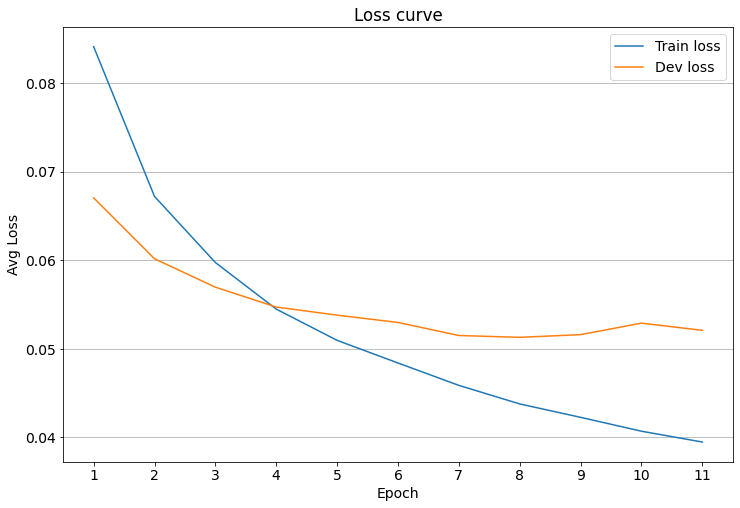

In [ ]:
if isinstance(model, Model34):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(history["train"]["loss"], label="Train loss")
    ax.plot(history["dev"]["loss"], label="Dev loss")

    n_actual_epochs = len(history["train"]["loss"])

    ax.set_xticks(range(n_actual_epochs))
    ax.set_xticklabels([i+1 for i in range(n_actual_epochs)])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Avg Loss")
    ax.set_title("Loss curve")
    ax.legend()
    ax.grid(axis='y')

    plt.show()

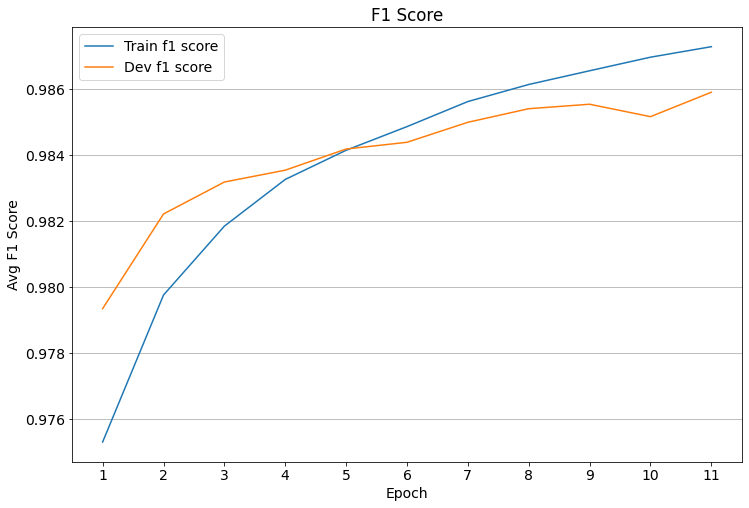

In [ ]:
if isinstance(model, Model34):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(history["train"]["f1_score"], label="Train f1 score")
    ax.plot(history["dev"]["f1_score"], label="Dev f1 score")

    n_actual_epochs = len(history["train"]["f1_score"])

    ax.set_xticks(range(n_actual_epochs))
    ax.set_xticklabels([i+1 for i in range(n_actual_epochs)])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Avg F1 Score")
    ax.set_title("F1 Score")
    ax.legend()
    ax.grid(axis='y')

plt.show()

### Task 234

In [ ]:
if isinstance(model, Model234):
    train_dataloader = DataLoader(train_dataset, hyperparams234["batch_size"], collate_fn=collate, shuffle=True)
    dev_dataloader = DataLoader(dev_dataset, hyperparams234["batch_size"], collate_fn=collate)

    loss_pf = nn.CrossEntropyLoss(ignore_index=pf_vocab['<pad>'])
    loss_srl = nn.CrossEntropyLoss(ignore_index=srl_vocab['<pad>'])
    alpha = len(srl_vocab) / len(pf_vocab)  # importance of pf term relative to srl
    loss_function = {"pf": loss_pf, "srl": loss_srl, "alpha": alpha}

    optimizer = optim.Adam(model.parameters(), lr=hyperparams234["lr"])

    trainer = Trainer234(model=model, 
                        loss_function=loss_function, 
                        optimizer=optimizer, 
                        device=DEVICE, 
                        verbose_level=2,
                        verbose_interval=10
                        )
    history = trainer.train(train_dataloader, dev_dataloader, n_epochs, 
                            collect_f1_score=True,
                            early_stopping=True, patience=3)

Training...



Bad dev epoch, patience for another 2 epoch(s).



Bad dev epoch, patience for another 2 epoch(s).



Bad dev epoch, patience for another 2 epoch(s).



Bad dev epoch, patience for another 2 epoch(s).



Bad dev epoch, patience for another 1 epoch(s).



Training interrupted by early stopping after 31 epochs.
Restoring model state.
Done!


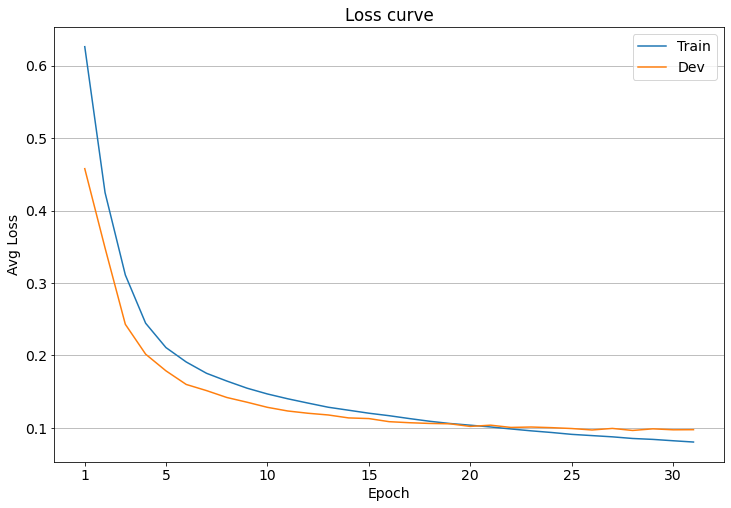

In [ ]:
if isinstance(model, Model234):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(history["train"]["loss"], label="Train")
    ax.plot(history["dev"]["loss"], label="Dev")

    n_actual_epochs = len(history["train"]["loss"])
    xticks = [0] + [n for n in range(n_actual_epochs) if (n+1) % 5 == 0]
    ax.set_xticks(xticks)
    ax.set_xticklabels([1] + [n for n in range(2, n_actual_epochs) if n % 5 == 0])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Avg Loss")
    ax.set_title("Loss curve")
    ax.legend()
    ax.grid(axis='y')

    plt.show()

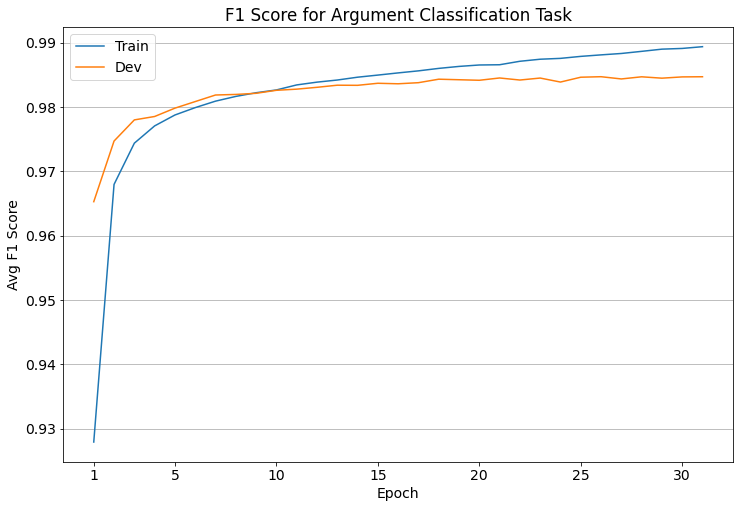

In [ ]:
if isinstance(model, Model234):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(history["train"]["f1_score"]["srl"], label="Train")
    ax.plot(history["dev"]["f1_score"]["srl"], label="Dev")

    n_actual_epochs = len(history["train"]["f1_score"]["srl"])
    xticks = [0] + [n for n in range(n_actual_epochs) if (n+1) % 5 == 0]
    ax.set_xticks(xticks)
    ax.set_xticklabels([1] + [n for n in range(2, n_actual_epochs) if n % 5 == 0])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Avg F1 Score")
    ax.set_title("F1 Score for Argument Classification Task")
    ax.legend()
    ax.grid(axis='y')

    plt.show()

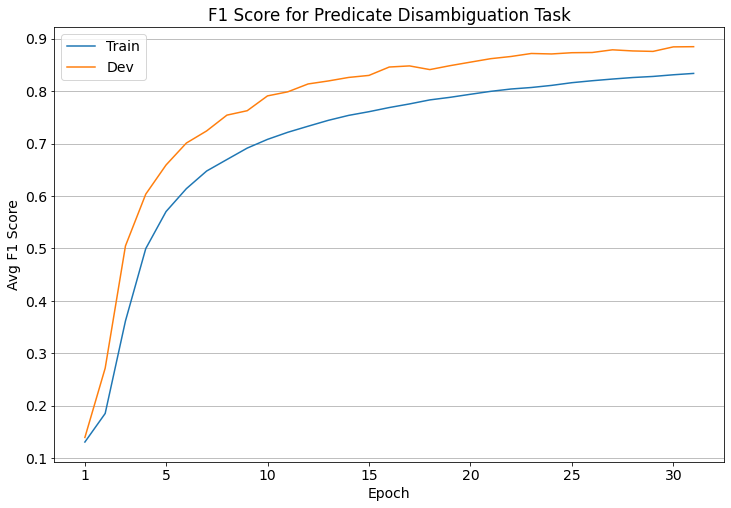

In [ ]:
if isinstance(model, Model234):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(history["train"]["f1_score"]["pf"], label="Train")
    ax.plot(history["dev"]["f1_score"]["pf"], label="Dev")

    n_actual_epochs = len(history["train"]["f1_score"]["pf"])
    xticks = [0] + [n for n in range(n_actual_epochs) if (n+1) % 5 == 0]
    ax.set_xticks(xticks)
    ax.set_xticklabels([1] + [n for n in range(2, n_actual_epochs) if n % 5 == 0])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Avg F1 Score")
    ax.set_title("F1 Score for Predicate Disambiguation Task")
    ax.legend()
    ax.grid(axis='y')

    plt.show()

# Model Evaluation

In [ ]:
model = trainer.model

In [ ]:
test_data = load_data(data_folder_path, "test.json")
test_dataset = CustomDataset(test_data)

test_bert_embeddings = torch.load(os.path.join(embeddings_folder_path, "test_bert_embeddings.pt"), 
                                  map_location=DEVICE)

test_dataset.encode_data(srl_vocab, pf_vocab, words_vocab, lemmas_vocab, pos_vocab,
                         test_bert_embeddings)

## Utilities

In [ ]:
def compute_predictions_34(model:nn.Module, device:str, 
                        dataloader:DataLoader, 
                        srl_vocab:SemanticRolesVocabulary) -> Tuple[list, list]:
    """
    Computes and returns all the true and predicted labels of a model on the dataset.

    Args:
        model:          The model to compute the predictions.
        device:         CPU or CUDA.
        dataloader:     The dataset to classify.
        label_dict:     The dictionary for the labels.
    
    Returns:
        The true and predicted labels for the data in dataset.
    """
    all_y_pred = list()
    all_y_true = list()
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing predictions", total=len(dataloader)):
            lengths = batch["length"].to(device)
            pred_frame = batch["pred_frame"].to(device)
            word = batch["word"].to(device)
            lemma = batch["lemma"].to(device)
            pos_tag = batch["pos_tag"].to(device)
            bert_sent = batch["bert_sent"].to(device)
            pred_pos = batch["pred_pos"].to(device)
            pred_mask = batch["pred_mask"].to(device)

            y_true = batch["srl"]

            y_pred = model(lengths, pred_frame, pred_pos, pred_mask, 
                           word, lemma, pos_tag, bert_sent)
            
            y_pred = torch.argmax(y_pred, -1).view(-1).cpu()
            y_true = y_true.view(-1)
            
            valid_indices = y_true != srl_vocab['<pad>']
            valid_labels = y_true[valid_indices]
            valid_predictions = y_pred[valid_indices]
            
            all_y_true.extend(valid_labels.tolist())
            all_y_pred.extend(valid_predictions.tolist())
    
    return all_y_true, all_y_pred

In [ ]:
def compute_predictions_234(model:nn.Module, device:str, 
                        dataloader:DataLoader, 
                        srl_vocab:SemanticRolesVocabulary,
                        pf_vocab:PredicateFramesVocabulary) -> Tuple[list, list, list, list]:
    """
    Computes and returns all the true and predicted labels of a model on the dataset.

    Args:
        model:          The model to compute the predictions.
        device:         CPU or CUDA.
        dataloader:     The dataset to classify.
        label_dict:     The dictionary for the labels.
    
    Returns:
        The true and predicted labels for the data in dataset.
    """
    all_true_pf = list()
    all_pred_pf = list()

    all_true_srl = list()
    all_pred_srl = list()

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing predictions", total=len(dataloader)):
            lengths = batch["length"].to(device)
            lemma = batch["lemma"].to(device)
            word = batch["word"].to(device)
            pos_tag = batch["pos_tag"].to(device)
            bert_sent = batch["bert_sent"].to(device)
            pred_pos = batch["pred_pos"].to(device)
            pred_mask = batch["pred_mask"].to(device)

            true_srl = batch["srl"].view(-1)
            true_pf = batch["pred_frame"].view(-1)

            pred_pf, pred_srl = model(lengths, pred_pos, pred_mask, 
                                      word, lemma, pos_tag, bert_sent)
            
            pred_pf = torch.argmax(pred_pf, -1).view(-1).cpu()
            pred_srl = torch.argmax(pred_srl, -1).view(-1).cpu()

            valid_indices = true_pf != pf_vocab['<pad>']
            valid_labels = true_pf[valid_indices]
            valid_predictions = pred_pf[valid_indices]

            all_true_pf.extend(valid_labels.tolist())
            all_pred_pf.extend(valid_predictions.tolist())

            valid_indices = true_srl != srl_vocab['<pad>']
            valid_labels = true_srl[valid_indices]
            valid_predictions = pred_srl[valid_indices]

            all_true_srl.extend(valid_labels.tolist())
            all_pred_srl.extend(valid_predictions.tolist())
    
    
    return all_true_pf, all_pred_pf, \
            all_true_srl, all_pred_srl

In [ ]:
def compute_classification_report(y_true:List[int], y_pred:List[int], 
                                  srl_vocab:SemanticRolesVocabulary, 
                                  ignored_labels=[]):
    """
    Computes and prints the classification report of the predictions of a model.

    Args:
        y_true:         Ground truth labels.
        y_pred:         Predicted labels.
        label_dict:     Vocabulary with the labels for decoding.
    """
    # discarding roles that are not in the test data
    for role, role_id in srl_vocab.stoi.items():
        if role_id not in y_true and role_id not in y_pred:
            if role not in ignored_labels:
                ignored_labels.append(role)

    print("Ignoring labels:", ignored_labels)

    print(classification_report(
        y_true, y_pred, zero_division=0, digits=4,
        labels=[i for l, i in srl_vocab.stoi.items() if l not in ignored_labels],
        target_names=[l for l, i in srl_vocab.stoi.items() if l not in ignored_labels]
    ))

## Saving model

In [ ]:
suffix = "15-07_Model234"

fname_model = "model_params_{}.pt".format(suffix)
fname_hparams = "hparams_{}.json".format(suffix)
fname_srl_vocab = "srl_vocab.json"
fname_pf_vocab = "pf_vocab.json"
fname_words_vocab = "words_vocab.json"
fname_lemmas_vocab = "lemmas_vocab.json"
fname_pos_vocab = "pos_vocab.json"

In [ ]:
save_model(model, model_folder_path, fname_model)
if isinstance(model, Model34):
    json_dump(hyperparams34, model_folder_path, fname_hparams)
elif isinstance(model, Model234):
    json_dump(hyperparams234, model_folder_path, fname_hparams)

# srl_vocab.save(model_folder_path, fname_srl_vocab)
# pf_vocab.save(model_folder_path, fname_pf_vocab)
# words_vocab.save(model_folder_path, fname_words_vocab)
# lemmas_vocab.save(model_folder_path, fname_lemmas_vocab)
# pos_vocab.save(model_folder_path, fname_pos_vocab)

## Loading model

In [ ]:
# hyperparams34 = json_load(os.path.join(model_folder_path, fname_hparams))
# model = Model34(hyperparams34)
# hyperparams234 = json_load(os.path.join(model_folder_path, fname_hparams))
# model = Model234(hyperparams234)
# model.to(DEVICE)
# load_model(model, os.path.join(model_folder_path, fname_model))

# srl_vocab = SemanticRolesVocabulary()
# pf_vocab = PredicateFramesVocabulary()
# words_vocab = WordsVocabulary()
# lemmas_vocab = LemmasVocabulary()
# pos_vocab = POSTagsVocabulary()

# srl_vocab.load(os.path.join(model_folder_path, fname_srl_vocab))
# pf_vocab.load(os.path.join(model_folder_path, fname_pf_vocab))
# words_vocab.load(os.path.join(model_folder_path, fname_words_vocab))
# lemmas_vocab.load(os.path.join(model_folder_path, fname_lemmas_vocab))
# pos_vocab.load(os.path.join(model_folder_path, fname_pos_vocab))

## Fine tuning

In [ ]:
# tunable_hyperparams34_grid = {
#     "hidden_dim": [64, 128, 256],
#     "pf_embedding_dim": [16, 64, 128],
#     "lemmas_embedding_dim": [16, 64, 128],
#     "pos_embedding_dim": [16, 64, 128],
#     "num_layers": [1, 2, 3],
#     "dropout": [0.1, 0.3, 0.5],
#     "lr": [1e-4, 5e-4, 1e-3],
# }

In [ ]:
# tunable_hyperparams34_grid = {
#     "hidden_dim": [64, 128, 256],
# }

In [ ]:
# tunable_hyperparams34_grid = {
#     "pf_embedding_dim": [32, 64, 128],
#     "lemmas_embedding_dim": [32, 64, 128],
#     "pos_embedding_dim": [32, 64, 128],
# }

In [ ]:
# tunable_hyperparams34_grid = {
#     "num_layers": [1, 2, 3],
#     "dropout": [0.1, 0.3, 0.5],
#     "lr": [1e-4, 5e-4, 1e-3],
# }

In [ ]:
fixed_hparams34 = {}
for key, value in hyperparams34.items():
    if key not in tunable_hyperparams34_grid:
        fixed_hparams34[key] = value

In [ ]:
def custom_f1_score(y_true, y_pred):
    y_true = y_true.detach().cpu()
    y_pred = y_pred.detach().cpu()
    y_pred = torch.argmax(y_pred, -1)
        
    valid_indices = y_true != srl_vocab['<pad>']
    valid_labels = y_true[valid_indices]
    valid_predictions = y_pred[valid_indices]

    y_true = valid_labels.numpy()
    y_pred = valid_predictions.numpy()

    batch_f1_score = f1_score(y_true, y_pred, average='macro')
    return batch_f1_score

def tune_train(model, train_loader, loss_function, optimizer, device=None):
    """
    Performs an epoch of training.
    """
    device = device or torch.device("cpu")
    model.train()
    
    n_batches = min(len(train_loader), MAX_TRAIN_BATCHES)
    batch_iterator = enumerate(train_loader)
    
    for batch_idx, batch in batch_iterator:
        if batch_idx > n_batches:
            break

        lengths = batch["length"].to(device)
        pred_frame = batch["pred_frame"].to(device)
        pred_pos = batch["pred_pos"].to(device)
        pred_mask = batch["pred_mask"].to(device)
        word = batch["word"].to(device)
        lemma = batch["lemma"].to(device)
        pos_tag = batch["pos_tag"].to(device)
        bert_sent = batch["bert_sent"].to(device)
        
        y_true = batch["srl"].to(device)

        optimizer.zero_grad()
                    
        y_pred = model(lengths, pred_frame, pred_pos, pred_mask, 
                            word, lemma, pos_tag, bert_sent)

        y_pred = y_pred.view(-1, y_pred.shape[-1])
        y_true = y_true.view(-1)
        
        batch_loss = loss_function(y_pred, y_true)
        batch_loss.backward()
        optimizer.step()


def tune_test(model, test_loader, device=None):
    """
    Performs an epoch of testing.
    """
    
    device = device or torch.device("cpu")
    model.eval()
    test_f1_score = 0.0
    
    n_batches = min(len(test_loader), MAX_TEST_BATCHES)
    
    with torch.no_grad():
        batch_iterator = enumerate(test_loader)
        for batch_idx, batch in batch_iterator:
            if batch_idx > n_batches:
                break

            lengths = batch["length"].to(device)
            pred_frame = batch["pred_frame"].to(device)
            word = batch["word"].to(device)
            lemma = batch["lemma"].to(device)
            pos_tag = batch["pos_tag"].to(device)
            bert_sent = batch["bert_sent"].to(device)
            pred_pos = batch["pred_pos"].to(device)
            pred_mask = batch["pred_mask"].to(device)
            
            y_true = batch["srl"].to(device)

            y_pred = model(lengths, pred_frame, pred_pos, pred_mask, 
                                    word, lemma, pos_tag, bert_sent)
            
            y_pred = y_pred.view(-1, y_pred.shape[-1])
            y_true = y_true.view(-1)

            test_f1_score += custom_f1_score(y_true, y_pred)
    
    return test_f1_score / len(test_loader)

def get_data_loaders():
    train_dataloader = DataLoader(train_dataset, hyperparams34["batch_size"], collate_fn=collate, shuffle=True)
    test_dataloader = DataLoader(test_dataset, hyperparams34["batch_size"], collate_fn=collate)
    return train_dataloader, test_dataloader

def tune(hparams_grid, n_training_epochs):
    """
    Fine tunes hyperparameters for Model34 performing a grid search.

    Args:
        hparams_grid:       the hyperparameters to tune and their specified ranges.
        n_training_epochs:  how many epochs to train for.

    Returns:
        The best combination of hyperparameters, in terms of test macro f1-score.
    """
    keys, values = zip(*hparams_grid.items())
    combinations_dict = [dict(zip(keys, v)) for v in itertools.product(*values)]
    trial_iterator = tqdm(combinations_dict, 
                          desc="Parameters grid search", 
                          total=len(combinations_dict))
    
    trials_history = []
    best_trial = None
    best_score = -1
    for config in trial_iterator:
        # trial_history = trial(config, n_training_epochs)

        device = torch.device("cuda")
        train_loader, test_loader = get_data_loaders()
        hparams = dict(config, **fixed_hparams34) # union of tunable and fixed hparams

        model = Model34(hparams).to(device)
        model_parameters = [param for param in model.parameters() if param.requires_grad]
        optimizer = optim.Adam(model_parameters, lr=hparams["lr"])
        loss_function = nn.CrossEntropyLoss(ignore_index=srl_vocab['<pad>'])

        trial_history = []
        epoch_iterator = range(n_training_epochs)
        epoch_iterator = tqdm(epoch_iterator, desc="Training model", leave=False)
        for _ in epoch_iterator:
            tune_train(model, train_loader, loss_function, optimizer, device)
            test_f1_score = tune_test(model, test_loader, device)
            trial_history.append(test_f1_score)
        
        score = max(trial_history)
        if score > best_score:
            best_trial = config
            best_score = score

        trials_history.append(trial_history)
    
    return trials_history, best_trial, best_score

In [ ]:
MAX_TRAIN_BATCHES = 32
MAX_TEST_BATCHES = 8

n_training_epochs = 10
trials_history, best_trial, best_score = tune(tunable_hyperparams34_grid, n_training_epochs)

In [ ]:
print(best_trial)

{'pf_embedding_dim': 128, 'lemmas_embedding_dim': 64, 'pos_embedding_dim': 16}


## Test predictions

### Task 34

In [ ]:
if isinstance(model, Model34):
    test_dataloader = DataLoader(test_dataset, hyperparams34["batch_size"], collate_fn=collate)
    test_true, test_pred = compute_predictions_34(model, DEVICE, test_dataloader, srl_vocab)
    compute_classification_report(test_true, test_pred, srl_vocab, ignored_labels=['<pad>'])

### Task 234

In [ ]:
if isinstance(model, Model234):    
    test_dataloader = DataLoader(test_dataset, hyperparams234["batch_size"], collate_fn=collate)
    test_true_pf, test_pred_pf, test_true_srl, test_pred_srl = compute_predictions_234(
        model, DEVICE, test_dataloader, srl_vocab, pf_vocab
    )

In [ ]:
if isinstance(model, Model234):
    compute_classification_report(test_true_pf, test_pred_pf, pf_vocab, ignored_labels=['<pad>'])

Ignoring labels: ['<pad>', 'ABSORB', 'CO-OPT', 'RISE_GO-UP', 'GIVE-BIRTH', 'EXHAUST', 'RESERVE', 'BULGE-OUT', 'KILL', 'FUND', 'FEED', 'TAKE-A-SERVICE_RENT', 'START-FUNCTIONING', 'COMMUNE', 'TAKE-INTO-ACCOUNT_CONSIDER', 'WASTE', 'CONTRACT-AN-ILLNESS_INFECT', 'CRY', 'CHANGE-HANDS', 'CELEBRATE_PARTY', 'EXTRACT', 'FIT', 'HAVE-SEX', 'MEAN', 'OVERLAP', 'STUDY', 'TOUCH', 'CONQUER', 'TAKE-SHELTER', 'DIET', 'ACCOMMODATE', 'CHANGE-TASTE', 'COIL', 'EXPLORE', 'FAKE', 'DIG-UP', 'FUEL', 'ISOLATE', 'TREAT', 'ALTERNATE', 'TYPE', 'LAUGH', 'SHOUT', 'BETRAY', 'PUSH-SOMEONE', 'BEFRIEND', 'SORT_CLASSIFY_ARRANGE', 'EMCEE', 'PUNISH', 'HOST_MEAL_INVITE', 'PARTICIPATE', 'SIMULATE', 'BORDER', 'SCORE', 'PARDON', 'AIR', 'DIRTY', 'COLOR', 'DRY', 'REST', 'LIGHTEN', 'CAVE_CARVE', 'EMPTY_UNLOAD', 'STRAIGHTEN', 'COMMUNIZE', 'EXALT', 'EXPOSE', 'SHARPEN', 'COMPLEXIFY', 'PRINT', 'CONVERT-CHEMICALLY/BIOLOGICALLY/PHYSICALLY', 'FLATTEN_SMOOTHEN', 'DIM', 'LOOSEN', 'LIGHT_SHINE', 'PROMOTE', 'LAND_GET-OFF', 'SPARKLE', 'POPULAT

In [ ]:
if isinstance(model, Model234):
    compute_classification_report(test_true_srl, test_pred_srl, srl_vocab, ignored_labels=['<pad>'])

Ignoring labels: ['<pad>', 'Idiom', 'Modifier']
              precision    recall  f1-score   support

           _     0.9958    0.9934    0.9946    119737
       Agent     0.9316    0.9419    0.9367      2719
       Theme     0.9180    0.9201    0.9190      2677
 Beneficiary     0.8737    0.8218    0.8469       101
   Attribute     0.7569    0.7942    0.7751       996
 Destination     0.7828    0.7461    0.7640       256
      Source     0.7941    0.8000    0.7970       135
  Instrument     0.7879    0.4127    0.5417        63
       Cause     0.6778    0.7439    0.7093        82
       Topic     0.8788    0.9312    0.9042       218
     Patient     0.8929    0.9259    0.9091       756
        Goal     0.8039    0.8092    0.8066       152
   Recipient     0.8304    0.9118    0.8692       102
      Result     0.8343    0.8391    0.8367       174
    Location     0.7802    0.8338    0.8061       349
       Asset     0.8594    0.8871    0.8730        62
     Purpose     0.6786    0.7170

## Ablation study

### Increasingly complex models

#### Baseline

In [ ]:
class BaselineModel34(nn.Module):
    def __init__(self, hparams):
        """
        A BiLSTM model with pre-trained BERT embeddings.

        Args:
            hparams:        Dictionary with the hyperparameters for the model.

        Attributes:
            lstm:           LSTM layer with dropout, can be bidirectional or not.
            dropout:        Dropout layer, with same amount of dropout used in lstm.
            linear:         Linear output layer.
        """
        super().__init__()

        self.words_embedding = nn.Embedding(hparams["num_words"],
                                             hparams["words_embedding_dim"])
        
        self.pf_embedding = nn.Embedding(hparams["num_pf"], 
                                          hparams["pf_embedding_dim"])

        input_dim = hparams["pf_embedding_dim"] + \
                        hparams["words_embedding_dim"]
                        
        self.hidden = nn.Linear(input_dim, hparams["hidden_dim"])
        self.bn = nn.BatchNorm1d(num_features=hparams["hidden_dim"])

        self.lstm = nn.LSTM(hparams["hidden_dim"], hparams["hidden_dim"], 
                            bidirectional=hparams["bidirectional"],
                            batch_first=True,
                            num_layers=hparams["num_layers"],
                            dropout=hparams["dropout"])

        lstm_output_dim = hparams["hidden_dim"] \
                            if hparams["bidirectional"] is False \
                            else 2*hparams["hidden_dim"]

        self.dropout = nn.Dropout(hparams["dropout"])
        self.classifier = nn.Linear(lstm_output_dim, hparams["num_classes"])
    
    def set_pretrained_word_embedding(self, embedding):
        self.words_embedding.weight.data.copy_(embedding)
        self.words_embedding.weight.requires_grad = False
    
    def forward(self, lengths, pred_frame, pred_pos, pred_mask,
                word, *args):
        """
        Args:
            lengths:    Tensor of lengths of sentences in the batch
                        (batch_size)
            pred_frame: Batch indices pointing to the predicate semantic frame
                        (batch_size)
            pred_pos:   Batch of indices pointing to the predicate position 
                        in the sentences
                        (batch_size)
            pred_mask:  Binary mask to indicate which sentences have predicates and which do not
                        (batch_size)
            word:       Batch of indices for the words of the sentences in the batch
                        (batch_size x seq_len x 1)
        """
        seq_len = word.shape[1]

        # (batch_size x pf_embedding_dim)
        pf_embeddings = self.dropout(self.pf_embedding(pred_frame))
        # (batch_size x seq_len x pf_embedding_dim)
        pf_embeddings = pf_embeddings.unsqueeze(1).repeat(1, seq_len, 1)

        # (batch_size x seq_len x words_embedding_dim)
        words_embeddings = self.dropout(self.words_embedding(word))

        # (batch_size x seq_len x 
        #   (pf_embedding_dim + words_embedding_dim))
        x = torch.cat((pf_embeddings, words_embeddings), dim=-1)
        
        # Hidden layer, batch normalization and dropout
        # (batch_size x seq_len x hidden_dim)
        x = self.hidden(x)
        x = self.bn(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout(x)
        
        # packing
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Fed it to lstm
        # (batch_size x seq_len x 2*hidden_dim)
        o, (h, c) = self.lstm(x)
        o, _ = pad_packed_sequence(o, batch_first=True, padding_value=0)

        o = self.dropout(o)
        o = self.classifier(o)
        return o

#### Baseline with joint (Predicate, Argument) classification

In [ ]:
class BaselinePredArgModel34(nn.Module):
    def __init__(self, hparams):
        """
        A BiLSTM model with pre-trained BERT embeddings.

        Args:
            hparams:        Dictionary with the hyperparameters for the model.

        Attributes:
            lstm:           LSTM layer with dropout, can be bidirectional or not.
            dropout:        Dropout layer, with same amount of dropout used in lstm.
            linear:         Linear output layer.
        """
        super().__init__()

        self.words_embedding = nn.Embedding(hparams["num_words"],
                                             hparams["words_embedding_dim"])
        
        self.pf_embedding = nn.Embedding(hparams["num_pf"], 
                                          hparams["pf_embedding_dim"])

        input_dim = hparams["pf_embedding_dim"] + \
                        hparams["words_embedding_dim"]
                        
        self.hidden = nn.Linear(input_dim, hparams["hidden_dim"])
        self.bn = nn.BatchNorm1d(num_features=hparams["hidden_dim"])

        self.lstm = nn.LSTM(hparams["hidden_dim"], hparams["hidden_dim"], 
                            bidirectional=hparams["bidirectional"],
                            batch_first=True,
                            num_layers=hparams["num_layers"],
                            dropout=hparams["dropout"])

        lstm_output_dim = hparams["hidden_dim"] \
                            if hparams["bidirectional"] is False \
                            else 2*hparams["hidden_dim"]

        self.dropout = nn.Dropout(hparams["dropout"])
        self.classifier = nn.Linear(2*lstm_output_dim, hparams["num_classes"])
    
    def set_pretrained_word_embedding(self, embedding):
        self.words_embedding.weight.data.copy_(embedding)
        self.words_embedding.weight.requires_grad = False
    
    def forward(self, lengths, pred_frame, pred_pos, pred_mask,
                word, *args):
        """
        Args:
            lengths:    Tensor of lengths of sentences in the batch
                        (batch_size)
            pred_frame: Batch indices pointing to the predicate semantic frame
                        (batch_size)
            pred_pos:   Batch of indices pointing to the predicate position 
                        in the sentences
                        (batch_size)
            pred_mask:  Binary mask to indicate which sentences have predicates and which do not
                        (batch_size)
            word:       Batch of indices for the words of the sentences in the batch
                        (batch_size x seq_len x 1)
        """
        seq_len = word.shape[1]

        # (batch_size x pf_embedding_dim)
        pf_embeddings = self.dropout(self.pf_embedding(pred_frame))
        # (batch_size x seq_len x pf_embedding_dim)
        pf_embeddings = pf_embeddings.unsqueeze(1).repeat(1, seq_len, 1)

        # (batch_size x seq_len x words_embedding_dim)
        words_embeddings = self.dropout(self.words_embedding(word))

        # (batch_size x seq_len x 
        #   (pf_embedding_dim + words_embedding_dim))
        x = torch.cat((pf_embeddings, words_embeddings), dim=-1)
        
        # Hidden layer, batch normalization and dropout
        # (batch_size x seq_len x hidden_dim)
        x = self.hidden(x)
        x = self.bn(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout(x)
        
        # packing
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Fed it to lstm
        # (batch_size x seq_len x 2*hidden_dim)
        o, (h, c) = self.lstm(x)
        o, _ = pad_packed_sequence(o, batch_first=True, padding_value=0)
        lstm_out_dim = o.shape[2]

        # Selecting predicate embedding for all the batch, 
        # to concatenate to each token in the sentence so that
        # the classifier gets pairs (token, predicate)
        
        # (batch_size x 1 x 2*hidden_dim)
        pred_pos = pred_pos.view(-1, 1, 1).repeat(1, 1, lstm_out_dim)

        # masking out the samples in the batch with no predicates
        # (batch_size x 1 x 2*hidden_dim)
        pred = o.gather(1, pred_pos)
        pred = pred * pred_mask[:, None, None]

        # (batch_size x seq_len x 2*hidden_dim)
        pred = pred.repeat(1, seq_len, 1)

        # (batch_size x seq_len x 4*hidden_dim)
        o = torch.cat((o, pred), dim=-1)

        o = self.dropout(o)
        o = self.classifier(o)
        return o

#### Lemmas

In [ ]:
class LemmasModel34(nn.Module):
    def __init__(self, hparams):
        """
        A BiLSTM model with pre-trained BERT embeddings.

        Args:
            hparams:        Dictionary with the hyperparameters for the model.

        Attributes:
            lstm:           LSTM layer with dropout, can be bidirectional or not.
            dropout:        Dropout layer, with same amount of dropout used in lstm.
            linear:         Linear output layer.
        """
        super().__init__()

        self.words_embedding = nn.Embedding(hparams["num_words"],
                                             hparams["words_embedding_dim"])

        self.lemmas_embedding = nn.Embedding(hparams["num_lemmas"],
                                             hparams["lemmas_embedding_dim"])
        
        self.pf_embedding = nn.Embedding(hparams["num_pf"], 
                                          hparams["pf_embedding_dim"])

        input_dim = hparams["pf_embedding_dim"] + \
                    hparams["words_embedding_dim"] + \
                    hparams["lemmas_embedding_dim"]
                        
        
        self.hidden = nn.Linear(input_dim, hparams["hidden_dim"])
        self.bn = nn.BatchNorm1d(num_features=hparams["hidden_dim"])

        self.lstm = nn.LSTM(hparams["hidden_dim"], hparams["hidden_dim"], 
                            bidirectional=hparams["bidirectional"],
                            batch_first=True,
                            num_layers=hparams["num_layers"],
                            dropout=hparams["dropout"])

        lstm_output_dim = hparams["hidden_dim"] \
                            if hparams["bidirectional"] is False \
                            else 2*hparams["hidden_dim"]

        self.dropout = nn.Dropout(hparams["dropout"])
        self.classifier = nn.Linear(2*lstm_output_dim, hparams["num_classes"])
    
    def set_pretrained_word_embedding(self, embedding):
        self.words_embedding.weight.data.copy_(embedding)
        self.words_embedding.weight.requires_grad = False
    
    def forward(self, lengths, pred_frame, pred_pos, pred_mask,
                word, lemma, *args):
        """
        Args:
            lengths:    Tensor of lengths of sentences in the batch
                        (batch_size)
            pred_frame: Batch indices pointing to the predicate semantic frame
                        (batch_size)
            pred_pos:   Batch of indices pointing to the predicate position 
                        in the sentences
                        (batch_size)
            pred_mask:  Binary mask to indicate which sentences have predicates and which do not
                        (batch_size)
            word:       Batch of indices for the words of the sentences in the batch
                        (batch_size x seq_len x 1)
            lemma:      Batch of indices for the lemmas of the sentences in the batch
                        (batch_size x seq_len x 1)
        """
        seq_len = word.shape[1]

        # (batch_size x pf_embedding_dim)
        pf_embeddings = self.dropout(self.pf_embedding(pred_frame))
        # (batch_size x seq_len x pf_embedding_dim)
        pf_embeddings = pf_embeddings.unsqueeze(1).repeat(1, seq_len, 1)

        # (batch_size x seq_len x words_embedding_dim)
        words_embeddings = self.dropout(self.words_embedding(word))

        # (batch_size x seq_len x lemmas_embedding_dim)
        lemmas_embeddings = self.dropout(self.lemmas_embedding(lemma))

        # (batch_size x seq_len x 
        #   (pf_embedding_dim + words_embedding_dim + lemmas_embedding_dim + pos_embedding_dim))
        x = torch.cat((pf_embeddings, words_embeddings, lemmas_embeddings), dim=-1)
        
        # (batch_size x seq_len x hidden_dim)
        x = self.hidden(x)
        x = self.bn(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout(x)
        
        # packing
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Fed it to lstm
        # (batch_size x seq_len x 2*hidden_dim)
        o, (h, c) = self.lstm(x)
        o, _ = pad_packed_sequence(o, batch_first=True, padding_value=0)
        lstm_out_dim = o.shape[2]

        # Selecting predicate embedding for all the batch, 
        # to concatenate to each token in the sentence so that
        # the classifier gets pairs (token, predicate)
        
        # (batch_size x 1 x 2*hidden_dim)
        pred_pos = pred_pos.view(-1, 1, 1).repeat(1, 1, lstm_out_dim)
        
        # masking out the samples in the batch with no predicates
        # (batch_size x 1 x 2*hidden_dim)
        pred = o.gather(1, pred_pos)
        pred = pred * pred_mask[:, None, None]

        # (batch_size x seq_len x 2*hidden_dim)
        pred = pred.repeat(1, seq_len, 1)

        # (batch_size x seq_len x 4*hidden_dim)
        o = torch.cat((o, pred), dim=-1)

        o = self.dropout(o)
        o = self.classifier(o)
        return o

#### POS

In [ ]:
class POSModel34(nn.Module):
    def __init__(self, hparams):
        """
        A BiLSTM model with pre-trained BERT embeddings.

        Args:
            hparams:        Dictionary with the hyperparameters for the model.

        Attributes:
            lstm:           LSTM layer with dropout, can be bidirectional or not.
            dropout:        Dropout layer, with same amount of dropout used in lstm.
            linear:         Linear output layer.
        """
        super().__init__()

        self.words_embedding = nn.Embedding(hparams["num_words"],
                                             hparams["words_embedding_dim"])

        self.lemmas_embedding = nn.Embedding(hparams["num_lemmas"],
                                             hparams["lemmas_embedding_dim"])
        
        self.pos_embedding = nn.Embedding(hparams["num_pos_tags"],
                                             hparams["pos_embedding_dim"])
        
        self.pf_embedding = nn.Embedding(hparams["num_pf"], 
                                          hparams["pf_embedding_dim"])

        input_dim = hparams["pf_embedding_dim"] + \
                        hparams["words_embedding_dim"] + \
                        hparams["lemmas_embedding_dim"] + \
                        hparams["pos_embedding_dim"]
                        
        
        self.hidden = nn.Linear(input_dim, hparams["hidden_dim"])
        self.bn = nn.BatchNorm1d(num_features=hparams["hidden_dim"])

        self.lstm = nn.LSTM(hparams["hidden_dim"], hparams["hidden_dim"], 
                            bidirectional=hparams["bidirectional"],
                            batch_first=True,
                            num_layers=hparams["num_layers"],
                            dropout=hparams["dropout"])

        lstm_output_dim = hparams["hidden_dim"] \
                            if hparams["bidirectional"] is False \
                            else 2*hparams["hidden_dim"]

        self.dropout = nn.Dropout(hparams["dropout"])
        self.classifier = nn.Linear(2*lstm_output_dim, hparams["num_classes"])
    
    def set_pretrained_word_embedding(self, embedding):
        self.words_embedding.weight.data.copy_(embedding)
        self.words_embedding.weight.requires_grad = False
    
    def forward(self, lengths, pred_frame, pred_pos, pred_mask,
                word, lemma, pos_tag, *args):
        """
        Args:
            lengths:    Tensor of lengths of sentences in the batch
                        (batch_size)
            pred_frame: Batch indices vectors pointing to the predicate semantic frame
                        (batch_size)
            pred_pos:   Batch of indices pointing to the predicate position 
                        in the sentences
                        (batch_size)
            pred_mask:  Binary mask to indicate which sentences have predicates and which do not
                        (batch_size)
            word:       Batch of indices for the words of the sentences in the batch
                        (batch_size x seq_len x 1)
            lemma:      Batch of indices for the lemmas of the sentences in the batch
                        (batch_size x seq_len x 1)
            pos_tag:    Batch of indices referring to the pos tags of the tokens in the sentences of the batch
                        (batch_size x seq_len x 1)
        """
        seq_len = word.shape[1]

        # (batch_size x pf_embedding_dim)
        pf_embeddings = self.dropout(self.pf_embedding(pred_frame))
        # (batch_size x seq_len x pf_embedding_dim)
        pf_embeddings = pf_embeddings.unsqueeze(1).repeat(1, seq_len, 1)

        # (batch_size x seq_len x words_embedding_dim)
        words_embeddings = self.dropout(self.words_embedding(word))

        # (batch_size x seq_len x lemmas_embedding_dim)
        lemmas_embeddings = self.dropout(self.lemmas_embedding(lemma))

        # (batch_size x seq_len x pos_embedding_dim)
        pos_embeddings = self.dropout(self.pos_embedding(pos_tag))
        
        # (batch_size x seq_len x 
        #   (pf_embedding_dim + words_embedding_dim + lemmas_embedding_dim + pos_embedding_dim))
        x = torch.cat((pf_embeddings, words_embeddings, lemmas_embeddings, pos_embeddings), dim=-1)
        
        # (batch_size x seq_len x hidden_dim)
        x = self.hidden(x)
        x = self.bn(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout(x)
        
        # packing
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Fed it to lstm
        # (batch_size x seq_len x 2*hidden_dim)
        o, (h, c) = self.lstm(x)
        o, _ = pad_packed_sequence(o, batch_first=True, padding_value=0)
        lstm_out_dim = o.shape[2]

        # Selecting predicate embedding for all the batch, 
        # to concatenate to each token in the sentence so that
        # the classifier gets pairs (token, predicate)
        
        # (batch_size x 1 x 2*hidden_dim)
        pred_pos = pred_pos.view(-1, 1, 1).repeat(1, 1, lstm_out_dim)
        
        # masking out the samples in the batch with no predicates
        # (batch_size x 1 x 2*hidden_dim)
        pred = o.gather(1, pred_pos)
        pred = pred * pred_mask[:, None, None]

        # (batch_size x seq_len x 2*hidden_dim)
        pred = pred.repeat(1, seq_len, 1)

        # (batch_size x seq_len x 4*hidden_dim)
        o = torch.cat((o, pred), dim=-1)

        o = self.dropout(o)
        o = self.classifier(o)
        return o

#### BERT

In [ ]:
class BERTModel34(nn.Module):
    def __init__(self, hparams):
        """
        A BiLSTM model with pre-trained BERT embeddings.

        Args:
            hparams:        Dictionary with the hyperparameters for the model.

        Attributes:
            lstm:           LSTM layer with dropout, can be bidirectional or not.
            dropout:        Dropout layer, with same amount of dropout used in lstm.
            linear:         Linear output layer.
        """
        super().__init__()

        self.words_embedding = nn.Embedding(hparams["num_words"],
                                             hparams["words_embedding_dim"])

        self.lemmas_embedding = nn.Embedding(hparams["num_lemmas"],
                                             hparams["lemmas_embedding_dim"])
        
        self.pos_embedding = nn.Embedding(hparams["num_pos_tags"],
                                             hparams["pos_embedding_dim"])
        
        self.pf_embedding = nn.Embedding(hparams["num_pf"], 
                                          hparams["pf_embedding_dim"])

        input_dim = hparams["pf_embedding_dim"] + \
                        hparams["words_embedding_dim"] + \
                        hparams["lemmas_embedding_dim"] + \
                        hparams["pos_embedding_dim"] + \
                        hparams["bert_embedding_dim"]
                        
        
        self.hidden = nn.Linear(input_dim, hparams["hidden_dim"])
        self.bn = nn.BatchNorm1d(num_features=hparams["hidden_dim"])

        self.lstm = nn.LSTM(hparams["hidden_dim"], hparams["hidden_dim"], 
                            bidirectional=hparams["bidirectional"],
                            batch_first=True,
                            num_layers=hparams["num_layers"],
                            dropout=hparams["dropout"])

        lstm_output_dim = hparams["hidden_dim"] \
                            if hparams["bidirectional"] is False \
                            else 2*hparams["hidden_dim"]

        self.dropout = nn.Dropout(hparams["dropout"])
        self.classifier = nn.Linear(2*lstm_output_dim, hparams["num_classes"])
    
    def set_pretrained_word_embedding(self, embedding):
        self.words_embedding.weight.data.copy_(embedding)
        self.words_embedding.weight.requires_grad = False
    
    def forward(self, lengths, pred_frame, pred_pos, pred_mask, 
                word, lemma, pos_tag, bert_sent):
        """
        Args:
            lengths:    Tensor of lengths of sentences in the batch
                        (batch_size)
            pred_frame: Batch indices vectors pointing to the predicate semantic frame
                        (batch_size)
            pred_pos:   Batch of indices pointing to the predicate position 
                        in the sentences
                        (batch_size)
            pred_mask:  Binary mask to indicate which sentences have predicates and which do not
                        (batch_size)
            word:       Batch of indices for the words of the sentences in the batch
                        (batch_size x seq_len x 1)
            lemma:      Batch of indices for the lemmas of the sentences in the batch
                        (batch_size x seq_len x 1)
            pos_tag:    Batch of indices referring to the pos tags of the tokens in the sentences of the batch
                        (batch_size x seq_len x 1)
            bert_sent:  Batch of sentences embedded by bert
                        (batch_size x seq_len x bert_embedding)
        """
        seq_len = word.shape[1]

        # (batch_size x pf_embedding_dim)
        pf_embeddings = self.dropout(self.pf_embedding(pred_frame))
        # (batch_size x seq_len x pf_embedding_dim)
        pf_embeddings = pf_embeddings.unsqueeze(1).repeat(1, seq_len, 1)

        # (batch_size x seq_len x words_embedding_dim)
        words_embeddings = self.dropout(self.words_embedding(word))

        # (batch_size x seq_len x lemmas_embedding_dim)
        lemmas_embeddings = self.dropout(self.lemmas_embedding(lemma))

        # (batch_size x seq_len x pos_embedding_dim)
        pos_embeddings = self.dropout(self.pos_embedding(pos_tag))
        
        # (batch_size x seq_len x 
        #   (pf_embedding_dim + words_embedding_dim + lemmas_embedding_dim + pos_embedding_dim + bert_embedding_dim))
        x = torch.cat((pf_embeddings, words_embeddings, lemmas_embeddings, pos_embeddings, bert_sent), dim=-1)
        
        # (batch_size x seq_len x hidden_dim)
        x = self.hidden(x)
        x = self.bn(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout(x)
        
        # packing
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Fed it to lstm
        # (batch_size x seq_len x 2*hidden_dim)
        o, (h, c) = self.lstm(x)
        o, _ = pad_packed_sequence(o, batch_first=True, padding_value=0)
        lstm_out_dim = o.shape[2]

        # Selecting predicate embedding for all the batch, 
        # to concatenate to each token in the sentence so that
        # the classifier gets pairs (token, predicate)
        
        # (batch_size x 1 x 2*hidden_dim)
        pred_pos = pred_pos.view(-1, 1, 1).repeat(1, 1, lstm_out_dim)
        
        # masking out the samples in the batch with no predicates
        # (batch_size x 1 x 2*hidden_dim)
        pred = o.gather(1, pred_pos)
        pred = pred * pred_mask[:, None, None]

        # (batch_size x seq_len x 2*hidden_dim)
        pred = pred.repeat(1, seq_len, 1)

        # (batch_size x seq_len x 4*hidden_dim)
        o = torch.cat((o, pred), dim=-1)

        o = self.dropout(o)
        o = self.classifier(o)
        return o

### Collect results

In [ ]:
n_epochs = 10
n_samples = int(round(0.1 * len(train_dataset)))

#### Baseline

In [ ]:
baseline_model = BaselineModel34(hyperparams34)
baseline_model.set_pretrained_word_embedding(pretrained_word_embeddings)

train_dataloader = DataLoader(train_dataset[:n_samples], hyperparams34["batch_size"], collate_fn=collate, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, hyperparams34["batch_size"], collate_fn=collate)

loss_function = nn.CrossEntropyLoss(ignore_index=srl_vocab['<pad>'])

# advisable to move the model to the proper device before creating optimizer for it
baseline_model.to(DEVICE)
model_parameters = [param for param in baseline_model.parameters() if param.requires_grad]
optimizer = optim.Adam(model_parameters, lr=hyperparams34["lr"])

trainer = Trainer34(model=baseline_model, 
                    loss_function=loss_function, 
                    optimizer=optimizer, 
                    device=DEVICE, 
                    verbose_level=2,
                    verbose_interval=10
                    )
baseline_history = trainer.train(train_dataloader, dev_dataloader, 
                        n_epochs, early_stopping=False)

Training...



Done!


#### Baseline with joint (Predicate, Argument) classification

In [ ]:
baseline_pred_arg_model = BaselinePredArgModel34(hyperparams34)
baseline_pred_arg_model.set_pretrained_word_embedding(pretrained_word_embeddings)

train_dataloader = DataLoader(train_dataset[:n_samples], hyperparams34["batch_size"], collate_fn=collate, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, hyperparams34["batch_size"], collate_fn=collate)

loss_function = nn.CrossEntropyLoss(ignore_index=srl_vocab['<pad>'])

# advisable to move the model to the proper device before creating optimizer for it
baseline_pred_arg_model.to(DEVICE)
model_parameters = [param for param in baseline_pred_arg_model.parameters() if param.requires_grad]
optimizer = optim.Adam(model_parameters, lr=hyperparams34["lr"])

trainer = Trainer34(model=baseline_pred_arg_model, 
                    loss_function=loss_function, 
                    optimizer=optimizer, 
                    device=DEVICE, 
                    verbose_level=2,
                    verbose_interval=10
                    )
baseline_pred_arg_history = trainer.train(train_dataloader, dev_dataloader, 
                        n_epochs, early_stopping=False)

Training...



Done!


#### Lemmas

In [ ]:
lemmas_model = LemmasModel34(hyperparams34)
lemmas_model.set_pretrained_word_embedding(pretrained_word_embeddings)

train_dataloader = DataLoader(train_dataset[:n_samples], hyperparams34["batch_size"], collate_fn=collate, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, hyperparams34["batch_size"], collate_fn=collate)

loss_function = nn.CrossEntropyLoss(ignore_index=srl_vocab['<pad>'])

# advisable to move the model to the proper device before creating optimizer for it
lemmas_model.to(DEVICE)
model_parameters = [param for param in lemmas_model.parameters() if param.requires_grad]
optimizer = optim.Adam(model_parameters, lr=hyperparams34["lr"])

trainer = Trainer34(model=lemmas_model, 
                    loss_function=loss_function, 
                    optimizer=optimizer, 
                    device=DEVICE, 
                    verbose_level=2,
                    verbose_interval=10
                    )
lemmas_history = trainer.train(train_dataloader, dev_dataloader, 
                        n_epochs, early_stopping=False)

Training...



Done!


#### POS

In [ ]:
pos_model = POSModel34(hyperparams34)
pos_model.set_pretrained_word_embedding(pretrained_word_embeddings)

train_dataloader = DataLoader(train_dataset[:n_samples], hyperparams34["batch_size"], collate_fn=collate, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, hyperparams34["batch_size"], collate_fn=collate)

loss_function = nn.CrossEntropyLoss(ignore_index=srl_vocab['<pad>'])

# advisable to move the model to the proper device before creating optimizer for it
pos_model.to(DEVICE)
model_parameters = [param for param in pos_model.parameters() if param.requires_grad]
optimizer = optim.Adam(model_parameters, lr=hyperparams34["lr"])

trainer = Trainer34(model=pos_model, 
                    loss_function=loss_function, 
                    optimizer=optimizer, 
                    device=DEVICE, 
                    verbose_level=2,
                    verbose_interval=10
                    )
pos_history = trainer.train(train_dataloader, dev_dataloader, 
                        n_epochs, early_stopping=False)

Training...



Done!


#### BERT

In [ ]:
bert_model = BERTModel34(hyperparams34)
bert_model.set_pretrained_word_embedding(pretrained_word_embeddings)

train_dataloader = DataLoader(train_dataset[:n_samples], hyperparams34["batch_size"], collate_fn=collate, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, hyperparams34["batch_size"], collate_fn=collate)

loss_function = nn.CrossEntropyLoss(ignore_index=srl_vocab['<pad>'])

# advisable to move the model to the proper device before creating optimizer for it
bert_model.to(DEVICE)
model_parameters = [param for param in bert_model.parameters() if param.requires_grad]
optimizer = optim.Adam(model_parameters, lr=hyperparams34["lr"])

trainer = Trainer34(model=bert_model, 
                    loss_function=loss_function, 
                    optimizer=optimizer, 
                    device=DEVICE, 
                    verbose_level=2,
                    verbose_interval=10
                    )
bert_history = trainer.train(train_dataloader, dev_dataloader, 
                        n_epochs, early_stopping=False)

Training...



Done!


### Compare results

#### Training metrics

##### Loss Curve Comparison

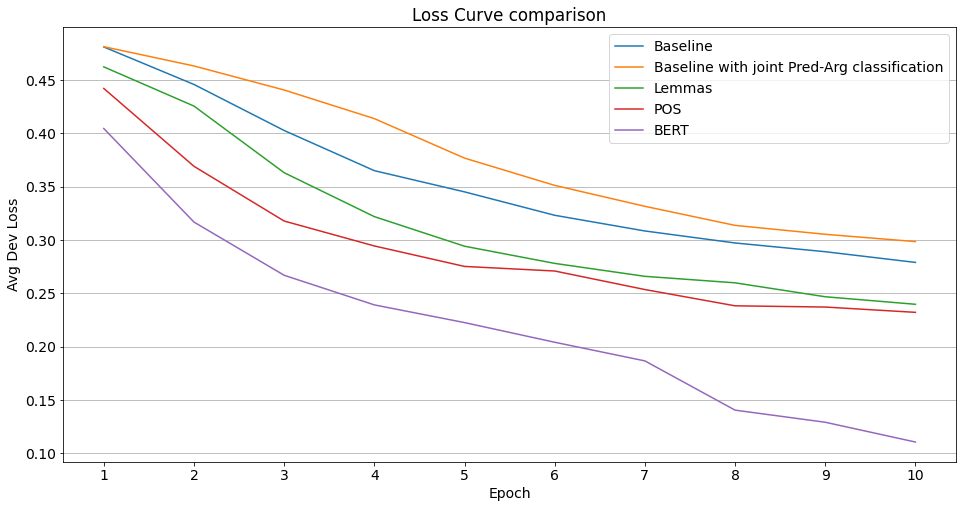

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(baseline_history["dev"]["loss"], label="Baseline")
ax.plot(baseline_pred_arg_history["dev"]["loss"], label="Baseline with joint Pred-Arg classification")
ax.plot(lemmas_history["dev"]["loss"], label="Lemmas")
ax.plot(pos_history["dev"]["loss"], label="POS")
ax.plot(bert_history["dev"]["loss"], label="BERT")

ax.set_xticks(range(n_epochs))
ax.set_xticklabels([i+1 for i in range(n_epochs)])
ax.set_xlabel("Epoch")
ax.set_ylabel("Avg Dev Loss")
ax.set_title("Loss Curve comparison")
ax.legend()
ax.grid(axis='y')

plt.show()

##### F1 Score Comparison

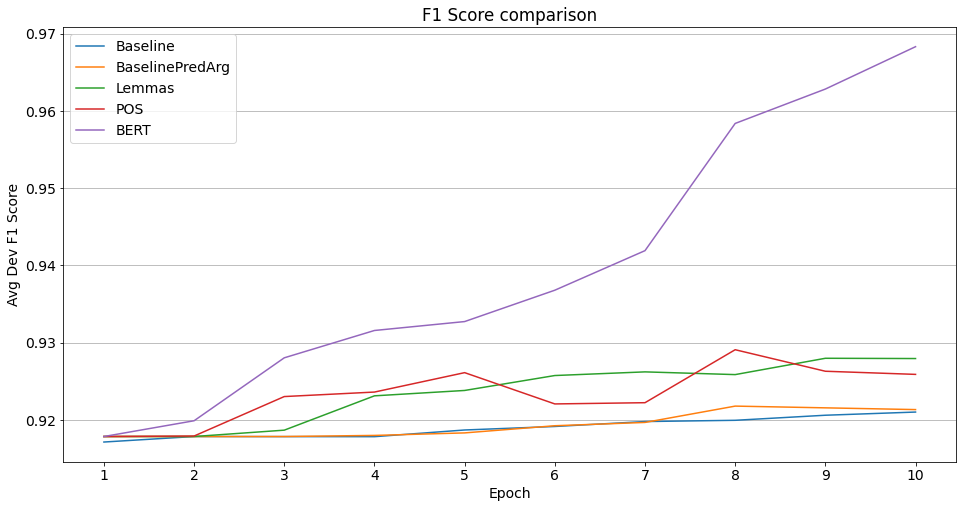

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(baseline_history["dev"]["f1_score"], label="Baseline")
ax.plot(baseline_pred_arg_history["dev"]["f1_score"], label="BaselinePredArg")
ax.plot(lemmas_history["dev"]["f1_score"], label="Lemmas")
ax.plot(pos_history["dev"]["f1_score"], label="POS")
ax.plot(bert_history["dev"]["f1_score"], label="BERT")

ax.set_xticks(range(n_epochs))
ax.set_xticklabels([i+1 for i in range(n_epochs)])
ax.set_xlabel("Epoch")
ax.set_ylabel("Avg Dev F1 Score")
ax.set_title("F1 Score comparison")
ax.legend()
ax.grid(axis='y')

plt.show()

#### Test predictions

In [ ]:
test_data = load_data(data_folder_path, "test.json")
test_dataset = CustomDataset(test_data)

# test_dataset.embed_data(bert_embedder)

# test_dataset.save_embeddings(model_path, "test_bert_embeddings.pt")

test_bert_embeddings = torch.load(os.path.join(embeddings_folder_path, "test_bert_embeddings.pt"), 
                             map_location=torch.device('cpu'))

test_dataset.encode_data(srl_vocab, pf_vocab, words_vocab, lemmas_vocab, pos_vocab,
                         test_bert_embeddings)

##### Baseline

In [ ]:
test_dataloader = DataLoader(test_dataset, hyperparams34["batch_size"], collate_fn=collate)
test_true, test_pred = compute_predictions_34(baseline_model, DEVICE, test_dataloader, srl_vocab)
compute_classification_report(test_true, test_pred, srl_vocab, ignored_labels=['<pad>'])


Ignoring labels: ['<pad>', 'Idiom', 'Modifier']
              precision    recall  f1-score   support

           _     0.9292    0.9876    0.9575    119737
       Agent     0.5860    0.3645    0.4494      2719
       Theme     0.6851    0.2406    0.3561      2677
 Beneficiary     0.4865    0.1782    0.2609       101
   Attribute     0.6533    0.0492    0.0915       996
 Destination     0.4745    0.2539    0.3308       256
      Source     1.0000    0.0370    0.0714       135
  Instrument     0.0000    0.0000    0.0000        63
       Cause     0.0000    0.0000    0.0000        82
       Topic     0.5238    0.0505    0.0921       218
     Patient     0.4770    0.1918    0.2736       756
        Goal     0.2500    0.0263    0.0476       152
   Recipient     0.0000    0.0000    0.0000       102
      Result     0.4359    0.0977    0.1596       174
    Location     0.9167    0.0315    0.0609       349
       Asset     0.6316    0.1935    0.2963        62
     Purpose     0.0000    0.000

##### Baseline with joint (Predicate, Argument) classification

In [ ]:
test_dataloader = DataLoader(test_dataset, hyperparams34["batch_size"], collate_fn=collate)
test_true, test_pred = compute_predictions_34(baseline_pred_arg_model, DEVICE, test_dataloader, srl_vocab)
compute_classification_report(test_true, test_pred, srl_vocab, ignored_labels=['<pad>'])


Ignoring labels: ['<pad>', 'Idiom', 'Modifier']
              precision    recall  f1-score   support

           _     0.9296    0.9873    0.9576    119737
       Agent     0.5635    0.3494    0.4313      2719
       Theme     0.7273    0.1614    0.2641      2677
 Beneficiary     0.3077    0.1584    0.2092       101
   Attribute     0.7600    0.0191    0.0372       996
 Destination     0.4065    0.1953    0.2639       256
      Source     0.0000    0.0000    0.0000       135
  Instrument     0.0000    0.0000    0.0000        63
       Cause     0.0000    0.0000    0.0000        82
       Topic     1.0000    0.0046    0.0091       218
     Patient     0.4719    0.1997    0.2807       756
        Goal     0.0000    0.0000    0.0000       152
   Recipient     0.0000    0.0000    0.0000       102
      Result     0.4167    0.0287    0.0538       174
    Location     0.5625    0.0258    0.0493       349
       Asset     0.3134    0.3387    0.3256        62
     Purpose     0.0000    0.000

##### Lemmas

In [ ]:
test_dataloader = DataLoader(test_dataset, hyperparams34["batch_size"], collate_fn=collate)
test_true, test_pred = compute_predictions_34(lemmas_model, DEVICE, test_dataloader, srl_vocab)
compute_classification_report(test_true, test_pred, srl_vocab, ignored_labels=['<pad>'])


Ignoring labels: ['<pad>', 'Idiom', 'Modifier']
              precision    recall  f1-score   support

           _     0.9474    0.9779    0.9624    119737
       Agent     0.6172    0.4814    0.5409      2719
       Theme     0.6053    0.4337    0.5053      2677
 Beneficiary     0.5493    0.3861    0.4535       101
   Attribute     0.5932    0.1054    0.1790       996
 Destination     0.6095    0.2500    0.3546       256
      Source     0.6154    0.3556    0.4507       135
  Instrument     0.0000    0.0000    0.0000        63
       Cause     0.0000    0.0000    0.0000        82
       Topic     0.5839    0.3991    0.4741       218
     Patient     0.4454    0.5344    0.4859       756
        Goal     0.6875    0.0724    0.1310       152
   Recipient     0.7059    0.2353    0.3529       102
      Result     0.5393    0.2759    0.3650       174
    Location     0.6269    0.1203    0.2019       349
       Asset     0.8750    0.2258    0.3590        62
     Purpose     1.0000    0.009

##### POS

In [ ]:
test_dataloader = DataLoader(test_dataset, hyperparams34["batch_size"], collate_fn=collate)
test_true, test_pred = compute_predictions_34(pos_model, DEVICE, test_dataloader, srl_vocab)
compute_classification_report(test_true, test_pred, srl_vocab, ignored_labels=['<pad>'])


Ignoring labels: ['<pad>', 'Idiom', 'Modifier']
              precision    recall  f1-score   support

           _     0.9567    0.9693    0.9630    119737
       Agent     0.5583    0.6234    0.5891      2719
       Theme     0.5650    0.5357    0.5500      2677
 Beneficiary     0.4082    0.1980    0.2667       101
   Attribute     0.5919    0.1908    0.2885       996
 Destination     0.4449    0.3945    0.4182       256
      Source     0.6625    0.3926    0.4930       135
  Instrument     0.0000    0.0000    0.0000        63
       Cause     0.0000    0.0000    0.0000        82
       Topic     0.4928    0.6284    0.5524       218
     Patient     0.4641    0.5820    0.5164       756
        Goal     0.6562    0.1382    0.2283       152
   Recipient     0.5682    0.4902    0.5263       102
      Result     0.4348    0.3448    0.3846       174
    Location     0.4907    0.2264    0.3098       349
       Asset     0.5526    0.3387    0.4200        62
     Purpose     0.5000    0.028

##### BERT

In [ ]:
test_dataloader = DataLoader(test_dataset, hyperparams34["batch_size"], collate_fn=collate)
test_true, test_pred = compute_predictions_34(bert_model, DEVICE, test_dataloader, srl_vocab)
compute_classification_report(test_true, test_pred, srl_vocab, ignored_labels=['<pad>'])


Ignoring labels: ['<pad>', 'Idiom', 'Modifier']
              precision    recall  f1-score   support

           _     0.9884    0.9888    0.9886    119737
       Agent     0.8617    0.8551    0.8584      2719
       Theme     0.7623    0.8566    0.8067      2677
 Beneficiary     0.6275    0.3168    0.4211       101
   Attribute     0.6272    0.6064    0.6166       996
 Destination     0.5918    0.5664    0.5788       256
      Source     0.5827    0.5481    0.5649       135
  Instrument     0.0000    0.0000    0.0000        63
       Cause     0.5789    0.4024    0.4748        82
       Topic     0.8211    0.7156    0.7647       218
     Patient     0.7982    0.8161    0.8071       756
        Goal     0.6308    0.2697    0.3779       152
   Recipient     0.5580    0.7549    0.6417       102
      Result     0.5692    0.6379    0.6016       174
    Location     0.6667    0.5845    0.6229       349
       Asset     0.6182    0.5484    0.5812        62
     Purpose     0.4222    0.717